In [1]:
#import numpy as np
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
import jax.scipy.stats as jsps
import jax.scipy.linalg as spla
from jax.config import config
config.update("jax_enable_x64", True)
from jax.scipy.stats import gaussian_kde

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy.spatial import ConvexHull

import gpjax as gpx
from jax import grad, jit
import jaxkern as jk
import optax as ox
from jaxutils import Dataset

In [2]:
from elliptical_slice_sampler_jax import elliptical_slice_jax
from plotting import plot_candidate

# Non-GP jax code

In [3]:
def K(kernel, xs, ys):
    """
    Compute a Gram matrix or vector from a kernel and an array of data points.
    Args:
    kernel: callable, maps pairs of data points to scalars.
    xs: array of data points, stacked along the leading dimension.
    Returns: A 2d array `a` such that `a[i, j] = kernel(xs[i], xs[j])`.
    """
    return jax.vmap(lambda x: jax.vmap(lambda y: kernel(x, y))(ys))(xs)

# Non GPjax code
def kernel_rbf(x1, x2):
    """
    Squared expoential kernel with lengthscale ls. 
    """
    ls=0.1; v=1
    #ls = params["lengthscale"]; v = params["variance"]
    return v * jnp.exp(-0.5 * jnp.linalg.norm(x1-x2) ** 2 / ls ** 2)




In [4]:


def make_preds(train_x, train_y, test_x):
    """
    Given data, get pred_mean and pred_cov. 
    
    TODO: change argument to data instead of train_x, train_y?
    """
    train_K = K(kernel_rbf, train_x, train_x) + 1e-6* jnp.eye(train_x.shape[0])
    cross_K = K(kernel_rbf, train_x, test_x)
    kappa_K = K(kernel_rbf, test_x, test_x)

    # Predictive parameters.
    train_cK = spla.cholesky(train_K)
    cross_solve = spla.cho_solve((train_cK,  False), cross_K)
    pred_mean = train_y.T @ cross_solve
    pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*jnp.eye(test_x.shape[0])
    
    return pred_mean, pred_cov

# Compute the convex envelope given x and y values
def convelope_old(knot_x, knot_y):
    d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, ls: kernel_old(x1, x2, ls)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))
    # TODO: 
    deriv_marg_var = jnp.max(jnp.diag(d_kernel(knot_x, knot_x, ls)))
    deriv_marg_var = 100
    s = jnp.linspace(-3*jnp.sqrt(deriv_marg_var), 3*jnp.sqrt(deriv_marg_var), 500)

    knot_y = jnp.atleast_2d(knot_y) # samples x num_primal
    print(knot_y.shape)
    sx = s[:,jnp.newaxis] * knot_x[jnp.newaxis,:] # num_dual x num_primal
    print(sx.shape)
    # compute the conjugate
    lft1 =jnp.max(sx[jnp.newaxis,:,:] - knot_y[:,jnp.newaxis,:],  axis=2) # samples x num_dual
    print(lft1.shape)
    # compute the biconjugate
    lft2 = jnp.max(sx[jnp.newaxis,:,:] - lft1[:,:,jnp.newaxis],  axis=1) # samples x num_primal
    return lft2

def get_next_candidate_baseline(data, designs, design_space):
    pred_mean, pred_cov, pred_cK, pred_Y, envelopes = update_model(data, 20, design_space)
    
    train_x, train_y = data
    
    # get covariances and compute log determinant
    covariances = jnp.array([make_preds(train_x, train_y, x)[1] for x in designs])
    entropy_change = 0.5 * jnp.linalg.slogdet(covariances + 1)[1]
    return entropy_change.argmax(), entropy_change

def update_model(data, T, design_space):
    N_designs = design_space.shape[0]
    train_x, train_y = data
    
    # TODO: add function to update model hyperparameters
    params = 1
    
    # sample functions ~ posterior
    pred_mean, pred_cov = make_preds(train_x, train_y, design_space) ### ? 
    pred_cK = spla.cholesky(pred_cov)
    # get T samples from the posterior
    pred_Y = pred_cK.T @ npr.randn(N_designs, T) + pred_mean[:,jnp.newaxis]
    # get s by computing the vector of tights w.r.t. posterior samples
    envelopes = convelope(design_space, pred_Y.T)
    
    return pred_mean, pred_cov, pred_cK, pred_Y, envelopes

# not needed anymore
def add_observation(data, true_y, next_x, design_space, design_inds):
    train_x, train_y = data
    #train_x = jnp.concatenate([train_x, jnp.array([design_space[design_inds[next_x]]])])
    #train_y = jnp.concatenate([train_y, jnp.array([true_y[design_inds[next_x]]])])
    train_x = jnp.concatenate([train_x, jnp.array([design_space[next_x]])])
    train_y = jnp.concatenate([train_y, jnp.array([true_y[next_x]])])
    return (train_x, train_y)


def plot_candidate_old(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes, data, next_x, scores, plot_eig=True, legend=True, plot_hulls=True):
    train_x, train_y = data
    
    plt.figure(figsize=(10,4))

    # Plot true function, convex hull, and GP model mean + uncertainty
    plt.plot(knot_x, true_y, "k", lw=2, label="True function")
    plt.plot(knot_x, true_envelope.T, ls="dashed", label="True envelope", lw=2, c="k")
    plt.plot(knot_x, pred_mean, lw=2, c="tab:blue", label="Model")
    y_err = jnp.sqrt(jnp.diag(pred_cov))
    plt.fill_between(knot_x, pred_mean - y_err, pred_mean + y_err, alpha=0.4, color="tab:blue")
    
    if plot_hulls:
        # Plot convex hulls of posterior samples
        plt.plot(knot_x, envelopes[:15,:].T, lw=0.5, c="gray")

    # Plot data / next evaluation
    plt.scatter(knot_x[next_x], true_y[next_x], marker="*", color="tab:red", zorder=5, sizes=[150], label="Next evaluation")
    plt.scatter(train_x, train_y, label="Observed data", c="k", zorder=5)

    # Plot the entropy estimates (i.e., -second term of EIG)
    if plot_eig:
        plt.scatter(knot_x, scores, c="purple", marker="|", label="EIG")
        
    if legend:
        plt.legend(ncol=2)

    plt.ylim(-3,3); plt.xlabel("Composition space"); plt.ylabel("Energy")
    
    
"""



def plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes, dataset, next_x, scores, plot_eig=True, legend=True, plot_hulls=True):
    #train_x, train_y = data
    
    plt.figure(figsize=(10,4))

    # Plot true function, convex hull, and GP model mean + uncertainty
    plt.plot(knot_x, true_y, "k", lw=2, label="True function")
    plt.plot(knot_x, true_envelope.T, ls="dashed", label="True envelope", lw=2, c="k")
    plt.plot(knot_x, pred_mean, lw=2, c="tab:blue", label="Model prediction")
    y_err = 2 * jnp.sqrt(jnp.diag(pred_cov))
    plt.fill_between(knot_x, pred_mean - y_err, pred_mean + y_err, alpha=0.4, color="tab:blue")
    
    if plot_hulls:
        # Plot convex hulls of posterior samples
        plt.plot(knot_x, envelopes[:15,:].T, lw=0.5, c="gray")

    # Plot data / next evaluation
    plt.scatter(next_x, get_next_y(true_y, knot_x[:,jnp.newaxis], next_x), marker="*", color="tab:red", zorder=5, sizes=[150], label="Next evaluation")
    plt.scatter(dataset.X, dataset.y, label="Observed data", c="k", zorder=5)

    # Plot the entropy estimates (i.e., -second term of EIG)
    if plot_eig:
        plt.scatter(knot_x, scores, c="purple", marker="|", label="EIG")
        
    if legend:
        plt.legend(ncol=2)

    plt.ylim(-3,3); plt.xlabel("Composition space"); plt.ylabel("Energy")
    
""";

In [5]:
def compute_distances(data, true_envelopes):
    distances = []
    for (i,x) in enumerate(data[0]):
        x_idx = (knot_x == x).argmax()
        distances.append(jnp.abs(data[1][i] - true_envelope[1][x_idx]))
    return jnp.array(distances)

def get_next_y(true_y, design_space, next_x):
    return true_y[:,jnp.newaxis][design_space == next_x]


In [6]:
def compute_IG_putative_x(putative_x, design_space, data, pred_cK, pred_Y, tights, rng_key, T=100, J=200):
    """
    Compute a Monte Carlo approximation of the IG w.r.t. T samples of s_t ~ p(s | data).
    
    The inner entropy is approximated via Monte Carlo + a KDE estimator constructed from the samples. 
    (TODO: don't use the same data twice)
    
    T: number of samples for the outer expectation
    J: number of ESS samples (controls the # of samples for the inner MC too?)
    """

    def entropy_est_wrap(args):
        tights_i, pred_Y_i = args
        return ess_and_estimate_entropy_test(putative_x, design_space, data, tights_i, pred_Y_i, pred_cK, rng_key, J=J)
    ventropy_est = jax.jit(jax.vmap(entropy_est_wrap, in_axes=((1,1),)))
    
    entropies = ventropy_est((tights, pred_Y))  
    #entropies = jnp.array([ess_and_estimate_entropy(putative_x, design_space, data, tights[:,i], pred_Y[:,i], pred_cK, rng_key, J=J) for i in range(len(tights))])
    
    # estimate of the second term in the EIG
    return entropies.mean()
    

def get_next_candidate(data, design_inds, design_space, rng_key, T=30, J=40, tol=1e-3):
    """
    Given current data and a list of designs, computes an IG score for each design. 
    
    T: number of outer MC samples
    J: number of inner MC samples
    tol: tolerance for considering what is tight w.r.t. the convex hull
    
    Returns the best design and the list of scores. 
    """
    

    # updates the model and samples T functions and computes their envelopes. here we evaluate functions only at points in the design space
    pred_mean, pred_cov, pred_cK, pred_Y, envelopes = update_model(data, T, design_space) 
    # compute the vector of indicators
    tights = jnp.abs(envelopes.T - pred_Y) < tol ## NOTE: we transposed the shape from what it was before
    
    # TODO: move the lambda function into the vmap to make it cleaner
    compute_IG_putative_wrap = lambda x: compute_IG_putative_x(x, design_space, data, pred_cK, pred_Y, tights, rng_key, T = T, J = J) 
    compute_IG_vmap = jax.jit(jax.vmap(compute_IG_putative_wrap, in_axes=0))
    
    #curr_entropy = jnp.log(jnp.sqrt(2*jnp.pi*jnp.e*jnp.diag(pred_cov[jnp.ix_(design_inds, design_inds)]))) # TOD0: need to index the relevant designs
    curr_entropy = 0.5 * jnp.log(2 * jnp.pi * jnp.e * jnp.diag(pred_cov)) 
    mean_entropy = compute_IG_vmap(design_space[design_inds,:])
    
    entropy_change = curr_entropy - mean_entropy
    return entropy_change.argmax(), entropy_change






# GP jax modeling code

In [7]:
def make_preds_gpjax(dataset, posterior, params, test_x, verbose=False):

    latent_distribution = posterior(params, dataset)(test_x)
    likelihood = gpx.Gaussian(num_datapoints = dataset.n)
    predictive_distribution = likelihood(params, latent_distribution)

    pred_mean = predictive_distribution.mean()
    pred_cov = predictive_distribution.covariance()
    
    return pred_mean, pred_cov

def update_model_gpjax(dataset, design_space, rng_key, update_params=False, num_iters=500, lr=1e-3):
    
    # Define model
    prior = gpx.Prior(kernel = jk.RBF())
    likelihood = gpx.Gaussian(num_datapoints = dataset.n)
    posterior = prior * likelihood
    
    if update_params:
        # Update hyperparameters
        mll = jit(posterior.marginal_log_likelihood(dataset, negative=True))
        opt = ox.adam(learning_rate=lr)
        parameter_state = gpx.initialise(posterior, key=rng_key)
        parameter_state = gpx.fit(mll, parameter_state, opt, num_iters=num_iters)
    else:
        # Use default parameters
        parameter_state = gpx.initialise(posterior, key=rng_key, 
                                         kernel={"lengthscale": jnp.array([0.1]), "variance": jnp.array([1])},
                                        likelihood={'obs_noise': jnp.array([0])})

    params = parameter_state.params
    pred_mean, pred_cov = make_preds_gpjax(dataset, posterior, params, design_space) ### ? 
    
    return pred_mean, pred_cov, posterior, params


def sample_from_posterior_gpjax(pred_mean, pred_cov, design_space, T):
    """
    Sample from the posterior predictive model
    """
    # TODO: clean this up -- not necessary
    #return pred_Y, envelopes, pred_cK


def get_next_candidate_baseline_gpjax(posterior, params, dataset, designs, design_space):
    # get covariances and compute log determinant
    covariances = jnp.array([make_preds_gpjax(dataset, posterior, params, x)[1] for x in designs])
    entropy_change = 0.5 * jnp.linalg.slogdet(covariances + 1)[1]
    return designs[entropy_change.argmax()], entropy_change

    
def get_next_candidate_baseline_gpjax(posterior, params, dataset, designs, design_space):
    # get covariances and compute log determinant
    covariances = jnp.array([make_preds_gpjax(dataset, posterior, params, x)[1] for x in designs])
    entropy_change = 0.5 * jnp.linalg.slogdet(covariances + 1)[1]
    return designs[entropy_change.argmax()], entropy_change


# Non-qhull version

In [8]:
def convelope(design_space, knot_y):

    N, D = design_space.shape
    deriv_marg_var = 100
    num_dual = 200
    d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, ls: kernel_old(x1, x2, ls)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))
    # TODO: 
    #deriv_marg_var = np.max(jnp.diag(d_kernel(knot_x, knot_x, ls)))
    #print(deriv_marg_var)
    s = jnp.linspace(-3*jnp.sqrt(deriv_marg_var), 3*jnp.sqrt(deriv_marg_var), num_dual)
    ss = jnp.meshgrid(*[s.ravel()]*D)
    s = jnp.array([sx.flatten() for sx in ss]).T

    knot_y = jnp.atleast_2d(knot_y) # samples x num_primal
    #print(knot_y.shape)
    
    prod = (design_space @ s.T).T
    #print(prod.shape)
    
    # compute the conjugate
    lft1 = jnp.max(prod[jnp.newaxis,:,:] - knot_y[:,jnp.newaxis,:],  axis=2) # samples x num_dual
    #print(lft1.shape)
    # compute the biconjugate
    lft2 = jnp.max(prod[jnp.newaxis,:,:] - lft1[:,:,jnp.newaxis],  axis=1) # samples x num_primal
    
    return lft2


def generate_true_function(design_space, knot_N): # todo: pass kernel as argument
    # TODO: make it such that we can pass in a dimension too? or just stick to 1d vs 2d. 
    #knot_x = jnp.linspace(0, 1, knot_N)
    knot_K = K(kernel_rbf, design_space, design_space) + 1e-8 * jnp.eye(knot_N)
    # Cholesky decomposition of the kernel matrix
    knot_cK = spla.cholesky(knot_K)
    # Form the true function of interest at knot_N number of points
    true_y = knot_cK.T @ npr.randn(knot_N)
    # compute envelope based on true function
    true_envelope = convelope(design_space, true_y)
    
    return true_y, true_envelope

def sample_from_posterior(pred_mean, pred_cov, design_space, T, get_env=False):
    # TODO: clean this up -- not necessary
    # sample functions ~ posterior
    N_designs = design_space.shape[0]
    pred_cK = spla.cholesky(pred_cov)
    # get T samples from the posterior
    pred_Y = pred_cK.T @ npr.randn(N_designs, T) + pred_mean[:, jnp.newaxis]
    # get s by computing the vector of tights w.r.t. posterior samples
    if get_env:
        envelopes = convelope(design_space, pred_Y.T)
    else:
        envelopes = None
    
    return pred_Y, envelopes, pred_cK

In [9]:
def generate_true_function_gpjax(design_space, knot_N): # todo: pass kernel as argument
    
    knot_K = K(kernel_rbf, design_space, design_space) + 1e-8 * jnp.eye(knot_N)
    # Cholesky decomposition of the kernel matrix
    knot_cK = spla.cholesky(knot_K)
    # Form the true function of interest at knot_N number of points
    true_y = knot_cK.T @ npr.randn(knot_N)
    # compute envelope based on true function
    true_envelope = convelope(design_space, true_y)
    
    return true_y, true_envelope

In [10]:
def ess_and_estimate_entropy(putative_x, design_space, data, s, y, cK, rng_key, J=50):
    """
    Get samples of function conditioned on tights, get samples of y preds conditioned on 
        these samples, and then estimate the entropy.
    """
    # sample J*3 number of points but only keep the last J 
    def same_tight(y, tight):
        new_hull = convelope(design_space, y).ravel()
        new_tight = np.abs(y - new_hull) < 1e-3
        return jnp.all(tight == new_tight)

    # samples of f given tights
    totsamps = J*3
    samps = elliptical_slice_jax(y.ravel(), lambda x: jnp.log(same_tight(x, s)), cK, totsamps, rng_key)
    test_samps = samps[totsamps-J:totsamps]
    
    # get 1d predictive y samples at values of design space
    def make_pred_single(train_y):
        pred_mean, pred_cov = make_preds(design_space, train_y, putative_x)
        return pred_mean.ravel()[0], pred_cov.ravel()[0]
    
    makepred_vmap = jax.jit(jax.vmap(make_pred_single, in_axes=(0,)))
    
    mus, sigmas = makepred_vmap(test_samps)
    
    ystars = jrnd.multivariate_normal(rng_key, mus, jnp.eye(len(mus))*sigmas) # TODO: just rescale by cholesky + mean
    
    # compute a KDE estimator of density p(y | s, data, putative_x)
    ypred_kde = jsps.gaussian_kde(ystars, bw_method='scott', weights=None)
    
    # evaluate the log probability on the samples y^{(j)}
    return -ypred_kde.logpdf(ystars).mean() # inner MC estimate    


def ess_and_estimate_entropy_noqhull(putative_x, design_space, data, s, y, cK, rng_key, J=50):
    """
    Get samples of function conditioned on tights, get samples of y preds conditioned on 
        these samples, and then estimate the entropy.
    """
    # sample J*3 number of points but only keep the last J 
    def same_tight(y, tight):
        new_hull = convelope(design_space, y).ravel()
        new_tight = y - new_hull < 1e-3
        return jnp.all(tight == new_tight)

    # samples of f given tights
    totsamps = J*3
    samps = elliptical_slice_jax(y.ravel(), lambda x: jnp.log(same_tight(x, s)), cK, totsamps, rng_key)
    test_samps = samps[totsamps-J:totsamps]
    
    x_ind = (putative_x == design_space).argmax()
    ystars = test_samps[:, x_ind]
    
    """
    # get 1d predictive y samples at values of design space
    def make_pred_single(train_y):
        pred_mean, pred_cov = make_preds(design_space, train_y, putative_x)
        return pred_mean.ravel()[0], pred_cov.ravel()[0]
    
    #make_pred_single_wrap = lambda yarg: make_pred_single(design_space, yarg, putative_x) ## TODO knot_x is global var here
    #makepred_vmap = jax.jit(jax.vmap(make_pred_single, in_axes=(0,)))
    
    mus, sigmas = makepred_vmap(test_samps)
    
    #vals = jnp.array([make_pred_single_wrap(ts) for ts in test_samps])
    #mus = vals[:,0]; sigmas = vals[:,1]
    ystars = jrnd.multivariate_normal(rng_key, mus, jnp.eye(len(mus))*sigmas) # TODO: just rescale by cholesky + mean
    #ystars = npr.multivariate_normal(mus, np.eye(len(mus))*sigmas) # TODO: just rescale by cholesky + mean
    """
    
    # compute a KDE estimator of density p(y | s, data, putative_x)
    ypred_kde = jsps.gaussian_kde(ystars, bw_method='scott', weights=None)
    
    # evaluate the log probability on the samples y^{(j)}
    return -ypred_kde.logpdf(ystars).mean() # inner MC estimate

def ess_and_estimate_entropy_gpjax(putative_x, design_space, dataset, posterior, params, s, y, cK, rng_key, J=50):
    """
    Get samples of function conditioned on tights, get samples of y preds conditioned on 
        these samples, and then estimate the entropy.
    """
    # sample J*3 number of points but only keep the last J 
    def same_tight(y, tight):
        new_hull = convelope(design_space, y).ravel()
        new_tight = y - new_hull < 1e-3
        return jnp.all(tight == new_tight)

    # samples of f given tights
    totsamps = J*3
    samps = elliptical_slice_jax(y.ravel(), lambda x: jnp.log(same_tight(x, s)), cK, totsamps, rng_key)
    test_samps = samps[totsamps-J:totsamps]
    
    # get 1d predictive y samples at values of design space
    #make_preds_gpjax(dataset, posterior, params, test_x, verbose=False)
    def make_pred_single(train_y):
        # make a prediction w.r.t. the full design space
        data_values = Dataset(X = design_space, y = train_y[:, jnp.newaxis])
        pred_mean, pred_cov = make_preds_gpjax(data_values, posterior, params, putative_x)
        return pred_mean.ravel()[0], pred_cov.ravel()[0]
    
    makepred_vmap = jax.jit(jax.vmap(make_pred_single, in_axes=(0,)))
    
    mus, sigmas = makepred_vmap(test_samps)
    ystars = jrnd.multivariate_normal(rng_key, mus, jnp.eye(len(mus))*sigmas) # TODO: just rescale by cholesky + mean
    
    # compute a KDE estimator of density p(y | s, data, putative_x)
    ypred_kde = jsps.gaussian_kde(ystars, bw_method='scott', weights=None)
    
    # evaluate the log probability on the samples y^{(j)}
    return -ypred_kde.logpdf(ystars).mean() # inner MC estimate
    #return estimate_entropy_cond_s(samps_f, putative_x, s, rng_key, J) 
    


In [11]:
def compute_IG_putative_x_noqhull(putative_x, design_space, dataset, posterior, params, pred_cK, pred_Y, tights, rng_key, T=100, J=200):
    """
    Compute a Monte Carlo approximation of the IG w.r.t. T samples of s_t ~ p(s | data).
    
    The inner entropy is approximated via Monte Carlo + a KDE estimator constructed from the samples. 
    (TODO: don't use the same data twice)
    
    T: number of samples for the outer expectation
    J: number of ESS samples (controls the # of samples for the inner MC too?)
    """

    def entropy_est_wrap(args):
        tights_i, pred_Y_i = args
        #breakpoint()
        return ess_and_estimate_entropy_gpjax(putative_x, design_space, dataset, posterior, params, tights_i, pred_Y_i, pred_cK, rng_key, J=J)
    #ess_and_estimate_entropy_gpjax(putative_x, design_space, dataset, posterior, params, s, y, cK, rng_key, J=50)
    
    ventropy_est = jax.jit(jax.vmap(entropy_est_wrap, in_axes=((1,1),)))
    #ventropy_est = jax.vmap(entropy_est_wrap, in_axes=((1,1),))

    entropies = ventropy_est((tights, pred_Y))  
    ##entropies = jnp.array([ess_and_estimate_entropy_gpjax_test(putative_x, design_space, dataset, posterior, params, tights[:,i], pred_Y[:,i], 
    ##                                                           pred_cK, rng_key, J=J) for i in range(len(tights))])
    
    # estimate of the second term in the EIG
    return entropies.mean()

In [12]:
def get_next_candidate_noqhull(posterior, params, dataset, designs, design_space, rng_key, T=30, J=40, tol=1e-3):
    """
    Given current data and a list of designs, computes an IG score for each design. 
    
    T: number of outer MC samples
    J: number of inner MC samples
    tol: tolerance for considering what is tight w.r.t. the convex hull
    
    Returns the best design and the list of scores. 
    """

    # updates the model and samples T functions and computes their envelopes. here we evaluate functions only at points in the design space
    #pred_mean, pred_cov, pred_cK, pred_Y, envelopes = update_model(data, T, design_space) 
    # compute the vector of indicators
    pred_mean, pred_cov = make_preds_gpjax(dataset, posterior, params, design_space)
    pred_Y, envelopes, pred_cK = sample_from_posterior(pred_mean, pred_cov, design_space, T, get_env=True)
    
    #breakpoint()
    tights = jnp.abs(envelopes.T - pred_Y) < tol ## NOTE: we transposed the shape from what it was before
    
    # TODO: move the lambda function into the vmap to make it cleaner
    compute_IG_putative_wrap = lambda x: compute_IG_putative_x_noqhull(x, design_space, dataset, posterior, params, pred_cK, pred_Y, tights, rng_key, T = T, J = J) 
    compute_IG_vmap = jax.jit(jax.vmap(compute_IG_putative_wrap, in_axes=0))
    
    print("vmapping")
    
    #breakpoint()
    
    # TODO: faster to find relevant indicies?
    _, pred_cov_designs = make_preds_gpjax(dataset, posterior, params, designs)
    #curr_entropy = jnp.log(jnp.sqrt(2 * jnp.pi * jnp.e * jnp.diag(pred_cov_designs)))
    curr_entropy = 0.5 * jnp.log(2 * jnp.pi * jnp.e * jnp.diag(pred_cov_designs)) 
    
    print("about to compute IG MAP")
    
    mean_entropy = compute_IG_vmap(designs)
    
    
    
    entropy_change = curr_entropy - mean_entropy
    return designs[entropy_change.argmax()], entropy_change





# Subroutines

In [13]:
"""
This module provides the ConvexHull class.
"""

import itertools
import numpy as np
from typing import List, Sized, Union
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull as ConvexHullSciPy
from scipy.spatial.qhull import QhullError

class ConvexHullMod:
    """This class provides functionality for extracting the convex hull
    of the (free) energy of mixing. It is based on the `convex hull
    calculator in SciPy
    <http://docs.scipy.org/doc/scipy-dev/reference/\
generated/scipy.spatial.ConvexHull.html>`_.
    Parameters
    ----------
    concentrations : list(float) or list(list(float))
        concentrations for each structure listed as ``[[c1, c2], [c1, c2],
        ...]``; for binaries, in which case there is only one independent
        concentration, the format ``[c1, c2, c3, ...]`` works as well.
    energies : list(float)
        energy (or energy of mixing) for each structure
    Attributes
    ----------
    concentrations : np.ndarray
        concentrations of the `N` structures on the convex hull
    energies : np.ndarray
        energies of the `N` structures on the convex hull
    dimensions : int
        number of independent concentrations needed to specify a point in
        concentration space (1 for binaries, 2 for ternaries etc.)
    structures : list(int)
        indices of structures that constitute the convex hull (indices are
        defined by the order of their concentrations and energies are fed when
        initializing the ConvexHull object)
    Examples
    --------
    A `ConvexHull` object is easily initialized by providing lists of
    concentrations and energies::
        >>> data = {'concentration': [0,    0.2,  0.2,  0.3,  0.4,  0.5,  0.8,  1.0],
        ...         'mixing_energy': [0.1, -0.2, -0.1, -0.2,  0.2, -0.4, -0.2, -0.1]}
        >>> hull = ConvexHull(data['concentration'], data['mixing_energy'])
    Now one can for example access the points along the convex hull directly::
        >>> for c, e in zip(hull.concentrations, hull.energies):
        ...     print(c, e)
        0.0 0.1
        0.2 -0.2
        0.5 -0.4
        1.0 -0.1
    or plot the convex hull along with the original data using e.g., matplotlib::
        >>> import matplotlib.pyplot as plt
        >>> plt.scatter(data['concentration'], data['mixing_energy'], color='darkred')
        >>> plt.plot(hull.concentrations, hull.energies)
        >>> plt.show(block=False)
    It is also possible to extract structures at or close to the convex hull::
        >>> low_energy_structures = hull.extract_low_energy_structures(
        ...     data['concentration'], data['mixing_energy'],
        ...     energy_tolerance=0.005)
    A complete example can be found in the :ref:`basic tutorial
    <tutorial_enumerate_structures>`.
    """

    def __init__(self,
                 concentrations: Union[List[float], List[List[float]]],
                 energies: List[float]) -> None:
        assert len(concentrations) == len(energies)
        # Prepare data in format suitable for SciPy-ConvexHull
        concentrations = np.array(concentrations)
        energies = np.array(energies)
        points = np.column_stack((concentrations, energies))
        self.dimensions = len(points[0]) - 1

        # Construct convex hull
        hull = ConvexHullSciPy(points,qhull_options='Qs')

        # Collect convex hull points in handy arrays
        concentrations = []  # type: ignore
        energies = []  # type: ignore
        for vertex in hull.vertices:
            if self.dimensions == 1:
                concentrations.append(points[vertex][0])
            else:
                concentrations.append(points[vertex][0:-1])
            energies.append(points[vertex][-1])
        concentrations = np.array(concentrations)
        energies = np.array(energies)

        structures = hull.vertices
        # If there is just one independent concentration, we'd better sort
        # according to it
        if self.dimensions == 1:
            ces = list(zip(*sorted(zip(concentrations, energies, structures))))
            self.concentrations = np.array(ces[0])
            self.energies = np.array(ces[1])
            self.structures = np.array(ces[2])
        else:
            self.concentrations = concentrations
            self.energies = energies
            self.structures = structures

        # Remove points that are above the "pure components plane"
        self._remove_points_above_tie_plane()

    def _remove_points_above_tie_plane(self, tol: float = 1e-3) -> None:
        """
        Remove all points on the convex hull that correspond to maximum rather
        than minimum energy.
        Parameters
        ----------
        tol
            Tolerance for what energy constitutes a lower one.
        """

        # Identify the "complex concentration hull", i.e. the extremal
        # concentrations. In the simplest case, these should simply be the
        # pure components.
        if self.dimensions == 1:
            # Then the ConvexHullScipy function doesn't work, so we just pick
            # the indices of the lowest and highest concentrations.
            vertices = []
            vertices.append(np.argmin(self.concentrations))
            vertices.append(np.argmax(self.concentrations))
            vertices = np.array(vertices)
        else:
            concentration_hull = ConvexHullSciPy(self.concentrations,qhull_options='Qs')
            vertices = concentration_hull.vertices

        # Remove all points of the convex energy hull that have an energy that
        # is higher than what would be gotten with pure components at the same
        # concentration. These points are mathematically on the convex hull,
        # but in the physically uninteresting upper part, i.e. they maximize
        # rather than minimize energy.
        to_delete = []
        for i, concentration in enumerate(self.concentrations):
            # The points on the convex concentration hull should always be
            # included, so skip them.
            if i in vertices:
                continue

            # The energy obtained as a linear combination of concentrations on
            # the convex hull is the "z coordinate" of the position on a
            # (hyper)plane in the (number of independent concentrations +
            # 1)-dimensional (N-D) space. This plane is spanned by N points.
            # If there are more vertices on the convex hull, we need to loop
            # over all combinations of N vertices.
            for plane in itertools.combinations(vertices,
                                                min(len(vertices),
                                                    self.dimensions + 1)):
                # Calculate energy that would be gotten with pure components
                # with ascribed concentration.
                energy_pure = griddata(self.concentrations[np.array(plane)],
                                       self.energies[np.array(plane)],
                                       concentration,
                                       method='linear')

                # Prepare to delete if the energy was lowered. `griddata` gives
                # NaN if the concentration is outside the triangle formed by
                # the three vertices. The result of the below comparison is
                # then False, which is what we want.
                if energy_pure < self.energies[i] - tol:
                    to_delete.append(i)
                    break

        # Finally remove all points
        self.concentrations = np.delete(self.concentrations, to_delete, 0)
        self.energies = np.delete(self.energies, to_delete, 0)
        self.structures = list(np.delete(self.structures, to_delete, 0))

    def get_energy_at_convex_hull(self, target_concentrations:
                                  Union[List[float],
                                        List[List[float]]]) -> np.ndarray:
        """Returns the energy of the convex hull at specified concentrations.
        If any concentration is outside the allowed range, NaN is
        returned.
        Parameters
        ----------
        target_concentrations
            concentrations at target points
            If there is one independent concentration, a list of
            floats is sufficient. Otherwise, the concentrations ought
            to be provided as a list of lists, such as ``[[0.1, 0.2],
            [0.3, 0.1], ...]``.
        """
        if self.dimensions > 1 and isinstance(target_concentrations[0], Sized):
            assert len(target_concentrations[0]) == self.dimensions

        # Loop over all complexes of N+1 points to make sure that the lowest
        # energy plane is used in the end. This is needed in two dimensions
        # but in higher.
        hull_candidate_energies = []
        for plane in itertools.combinations(range(len(self.energies)),
                                            min(len(self.energies),
                                                self.dimensions + 1)):
            try:
                plane_energies = griddata(self.concentrations[list(plane)],
                                          self.energies[list(plane)],
                                          np.array(target_concentrations),
                                          method='linear')
            except QhullError:
                # If the points lie on a line, the convex hull will fail, but
                # we do not need to care about these "planes" anyway
                continue
            hull_candidate_energies.append(plane_energies)

        # Pick out the lowest energies found
        hull_energies = np.nanmin(hull_candidate_energies, axis=0)
        return hull_energies

    def extract_low_energy_structures(self, concentrations:
                                      Union[List[float],
                                            List[List[float]]],
                                      energies: List[float],
                                      energy_tolerance: float) -> List[int]:
        """Returns the indices of energies that lie within a certain
        tolerance of the convex hull.
        Parameters
        ----------
        concentrations
            concentrations of candidate structures
            If there is one independent concentration, a list of
            floats is sufficient. Otherwise, the concentrations must
            be provided as a list of lists, such as ``[[0.1, 0.2],
            [0.3, 0.1], ...]``.
        energies
            energies of candidate structures
        energy_tolerance
            include structures with an energy that is at most this far
            from the convex hull
        """
        # Convert to numpy arrays, can be necessary if, for example,
        # they are Pandas Series with "gaps"
        concentrations = np.array(concentrations)
        energies = np.array(energies)

        n_points = len(concentrations)
        if len(energies) != n_points:
            raise ValueError('concentrations and energies must have '
                             'the same length')

        # Calculate energy at convex hull for specified concentrations
        hull_energies = self.get_energy_at_convex_hull(concentrations)

        # Extract those that are close enough
        close_to_hull = [i for i in range(n_points)
                         if energies[i] <= hull_energies[i] + energy_tolerance]

        return close_to_hull
    
    
    
def convex_envelope_new(x, fs):
    
    data = {"concentration": x, "mixing_energy": fs}

    hull = ConvexHullMod(data['concentration'], data['mixing_energy'])
    return np.array(hull.structures)

/var/folders/4v/yjlz4wlj08n26k6x_vpckx500000gn/T/ipykernel_32438/204917221.py:10: DeprecationWarning: Please use `QhullError` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import QhullError


In [14]:
def convex_envelope(x, fs):
    """Computes convex envelopes of M functions which share a common grid.
    x is an (N, D)-matrix corresponding to the grid in D-dimensional space and fs is an (M, N)-matrix.
    The i-th function is given by the pairs (x[0], fs[i, 0]), ..., (x[N-1], fs[i, N-1]).
    The envelopes are returned as a list of lists.
    The i-th list is of the form [j_1, j_2, ..., j_n] where (X[j_k], fs[i, j_k]) is a point in the envelope.
    
    Keyword arguments:
    x  -- A shape=(N,D) numpy array.
    fs -- A shape=(M,N) or shape=(N,) numpy array."""
    
    assert(len(fs.shape) <= 2)
    if len(fs.shape) == 1: fs = np.reshape(fs, (-1, fs.shape[0]))
    M, N = fs.shape
    
    assert(len(x.shape) <= 2)
    if len(x.shape) == 1: x = np.reshape(x, (-1, 1))
    assert(x.shape[0] == N)
    D = x.shape[1]
    
    fs_pad = np.empty((M, N+2))
    fs_pad[:, 1:-1], fs_pad[:, (0,-1)] = fs, np.max(fs) + 1. ## TODO: can't do this
    
    x_pad = np.empty((N+2, D))
    x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]
    
    results = []
    for i in range(M):
        epi = np.column_stack((x_pad, fs_pad[i, :]))
        hull = ConvexHull(epi)
        result = [v-1 for v in hull.vertices if 0 < v <= N]
        result.sort()
        results.append(np.array(result))
    
    return np.array(results)[0]

In [15]:
from scipy.spatial import ConvexHull
import numpy as np

def convex_envelope(x, fs):
    """Computes convex envelope.
    x is an (N, D)-matrix corresponding to the grid in D-dimensional space and fs is an (N, N)-matrix.
    
    Arguments:
    x: (N,D) numpy array.
    y: (N,1) or shape=(N,) numpy array."""

    if len(fs.shape) == 1: fs = np.reshape(fs, (fs.shape[0], -1))
    N, _ = fs.shape
    D = x.shape[1]

    # compute epigraph 
    fs_pad = np.empty((N+2, 1))
    fs_pad[1:-1] = fs
    fs_pad[(0,-1)] = np.max(fs) + 1
    
    x_pad = np.empty((N+2, D))
    x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]
    
    epi = np.column_stack((x_pad, fs_pad))
    hull = ConvexHull(epi)
    result = [v - 1 for v in hull.vertices if 0 < v <= N]
    
    return np.array(result)

def is_vertex(points):
    N, D = points.shape
    vertices = convex_envelope_new(points[:, :-1], points[:, -1])
    #vertices = convex_envelope(points[:, :-1], points[:, -1])
    s = np.zeros(N)
    s[vertices] = 1
    return s.astype("bool")

@jit
def is_tight(design_space, true_y):

    points = jnp.hstack([design_space, true_y[:, jnp.newaxis]])
    _scipy_hull = lambda points: is_vertex(points) 

    result_shape_dtype = jax.ShapeDtypeStruct(
          shape=jnp.broadcast_shapes(true_y.shape),
          dtype='bool')

    return jax.pure_callback(_scipy_hull, result_shape_dtype, points, vectorized=False)

In [16]:
def ess_and_estimate_entropy_gpjax_test(putative_x, design_space, dataset, posterior, params, s, y, cK, rng_key, J=50):
    """
    Get samples of function conditioned on tights, get samples of y preds conditioned on 
        these samples, and then estimate the entropy.
    """
    # sample J*3 number of points but only keep the last J 
    #def same_tight(y, tight):
    #    new_hull = convelope(design_space, y).ravel()
    #    new_tight = y - new_hull < 1e-3
    #    return jnp.all(tight == new_tight)
    
    def same_tight_1d(y, tight):
        new_hull = convelope(design_space, y).ravel()
        new_tight = y - new_hull < 1e-3
        return jnp.all(tight == new_tight)

    def same_tight(y, tight):
        new_tight = is_tight(design_space, y)
        return jnp.all(tight == new_tight)

    # samples of f given tights
    totsamps = J*3
    #breakpoint()
    samps = elliptical_slice_jax(y.ravel(), lambda x: jnp.log(same_tight(x, s)), cK, totsamps, rng_key)
    test_samps = samps[totsamps-J:totsamps]
    
    x_ind = (putative_x == design_space).argmax()
    ystars = test_samps[:, x_ind]
    
    """
    # get 1d predictive y samples at values of design space
    #make_preds_gpjax(dataset, posterior, params, test_x, verbose=False)
    def make_pred_single(train_y):
        # make a prediction w.r.t. the full design space
        data_values = Dataset(X = design_space, y = train_y[:, jnp.newaxis])
        pred_mean, pred_cov = make_preds_gpjax(data_values, posterior, params, putative_x)
        return pred_mean.ravel()[0], pred_cov.ravel()[0]
    
    makepred_vmap = jax.jit(jax.vmap(make_pred_single, in_axes=(0,)))
    
    mus, sigmas = makepred_vmap(test_samps)
    ystars = jrnd.multivariate_normal(rng_key, mus, jnp.eye(len(mus))*sigmas) # TODO: just rescale by cholesky + mean
    """
    
    # compute a KDE estimator of density p(y | s, data, putative_x)
    ypred_kde = jsps.gaussian_kde(ystars, bw_method='scott', weights=None)
    
    # evaluate the log probability on the samples y^{(j)}
    return -ypred_kde.logpdf(ystars).mean() # inner MC estimate
    #return estimate_entropy_cond_s(samps_f, putative_x, s, rng_key, J) 
    


In [17]:
def compute_IG_putative_x_gpjax(putative_x, design_space, dataset, posterior, params, pred_cK, pred_Y, tights, rng_key, T=100, J=200):
    """
    Compute a Monte Carlo approximation of the IG w.r.t. T samples of s_t ~ p(s | data).
    
    The inner entropy is approximated via Monte Carlo + a KDE estimator constructed from the samples. 
    (TODO: don't use the same data twice)
    
    T: number of samples for the outer expectation
    J: number of ESS samples (controls the # of samples for the inner MC too?)
    """

    def entropy_est_wrap(args):
        tights_i, pred_Y_i = args
        #breakpoint()
        return ess_and_estimate_entropy_gpjax_test(putative_x, design_space, dataset, posterior, params, tights_i, pred_Y_i, pred_cK, rng_key, J=J)
    #ess_and_estimate_entropy_gpjax(putative_x, design_space, dataset, posterior, params, s, y, cK, rng_key, J=50)
    
    ventropy_est = jax.jit(jax.vmap(entropy_est_wrap, in_axes=((1,1),)))
    #ventropy_est = jax.vmap(entropy_est_wrap, in_axes=((1,1),))

    entropies = ventropy_est((tights, pred_Y))  
    ##entropies = jnp.array([ess_and_estimate_entropy_gpjax_test(putative_x, design_space, dataset, posterior, params, tights[:,i], pred_Y[:,i], 
    ##                                                           pred_cK, rng_key, J=J) for i in range(len(tights))])
    
    # estimate of the second term in the EIG
    return entropies.mean()
    

def get_next_candidate_qhull(posterior, params, dataset, designs, design_space, rng_key, T=30, J=40, tol=1e-3):
    """
    Given current data and a list of designs, computes an IG score for each design. 
    
    T: number of outer MC samples
    J: number of inner MC samples
    tol: tolerance for considering what is tight w.r.t. the convex hull
    
    Returns the best design and the list of scores. 
    """

    # updates the model and samples T functions and computes their envelopes. here we evaluate functions only at points in the design space
    #pred_mean, pred_cov, pred_cK, pred_Y, envelopes = update_model(data, T, design_space) 
    # compute the vector of indicators
    pred_mean, pred_cov = make_preds_gpjax(dataset, posterior, params, design_space)
    pred_Y, _, pred_cK = sample_from_posterior(pred_mean, pred_cov, design_space, T, get_env=False)
        
    #breakpoint()
    #tights = jnp.abs(envelopes.T - pred_Y) < tol ## NOTE: we transposed the shape from what it was before
    get_tights = jax.jit(jax.vmap(lambda y: is_tight(design_space, y), in_axes=(1,)))
    tights = get_tights(pred_Y).T
    
    
    # TODO: move the lambda function into the vmap to make it cleaner
    compute_IG_putative_wrap = lambda x: compute_IG_putative_x_gpjax(x, design_space, dataset, posterior, params, pred_cK, pred_Y, tights, rng_key, T = T, J = J) 
    compute_IG_vmap = jax.jit(jax.vmap(compute_IG_putative_wrap, in_axes=0))
    
    
    # TODO: faster to find relevant indicies?
    _, pred_cov_designs = make_preds_gpjax(dataset, posterior, params, designs)
    #curr_entropy = jnp.log(jnp.sqrt(2 * jnp.pi * jnp.e * jnp.diag(pred_cov_designs)))
    curr_entropy = 0.5 * jnp.log(2 * jnp.pi * jnp.e * jnp.diag(pred_cov_designs)) 
    
    mean_entropy = compute_IG_vmap(designs)
    
    
    
    entropy_change = curr_entropy - mean_entropy
    return designs[entropy_change.argmax()], entropy_change



# Non Qhull version

In [18]:
seed = 2
num_iters = 3
knot_N = 40
npr.seed(seed); rng_key = jrnd.PRNGKey(1)

# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

true_y, true_envelope = generate_true_function(design_space, knot_N)

# Let's imagine that we start out by observing the two end points.
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])

#designs = design_space
designs = design_space[1:-1]


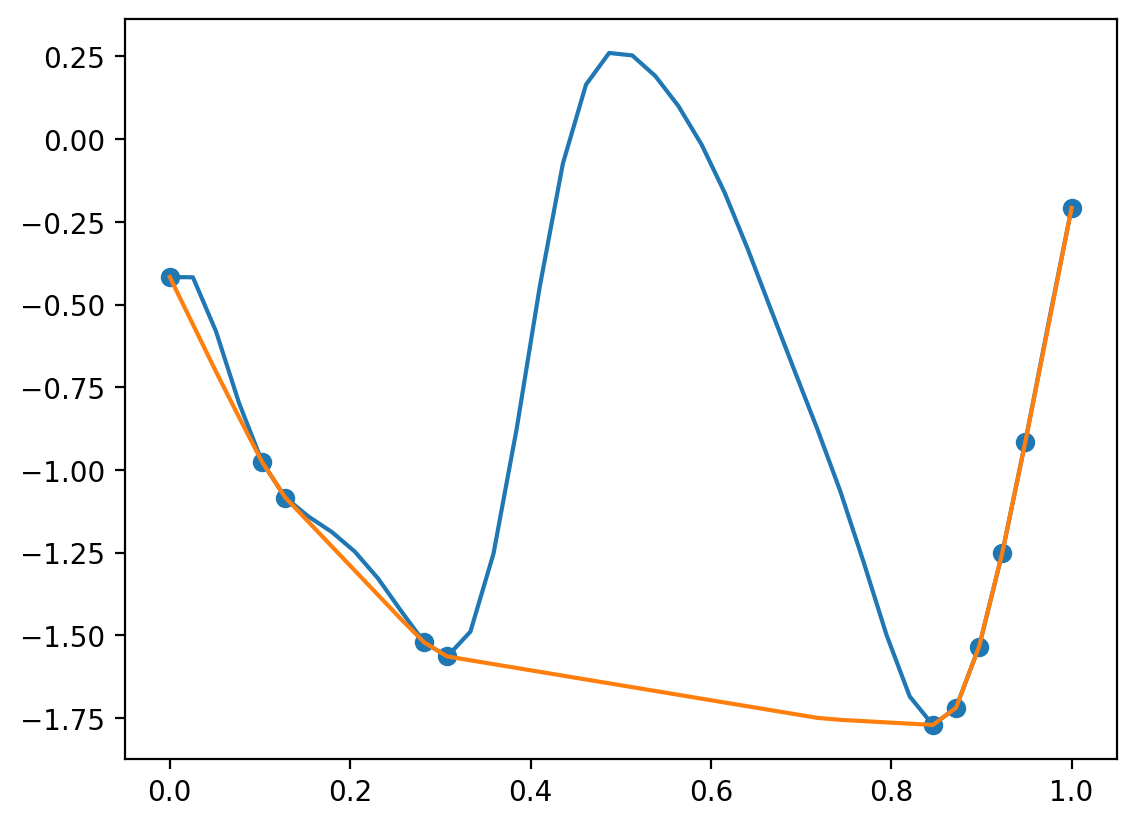

In [19]:
plt.plot(design_space, true_y)
plt.plot(design_space, true_envelope.T)

# this doesn't compute the hull, just the points on the hull
conv = convex_envelope(design_space, true_y)
plt.scatter(design_space[conv], true_y[conv])

In [20]:
# update model
pred_mean, pred_cov, posterior, params = update_model_gpjax(dataset, design_space, rng_key, update_params=False)

Iteration:  0
vmapping
about to compute IG MAP
CPU times: user 11.2 s, sys: 323 ms, total: 11.6 s
Wall time: 10.6 s
[0.07692308] [1.61970009 1.69549451 1.74128976 1.73649854 1.71870799 1.68276696
 1.65815079 1.62016149 1.54204427 1.41916348 1.34165077 1.31096248
 1.32187072 1.35364398 1.3893062  1.40113788 1.3694733  1.32564973
 1.29276472 1.278926   1.26538467 1.26368734 1.26490941 1.27876527
 1.29654856 1.31795259 1.34841912 1.36761106 1.38119322 1.40141501
 1.4413515  1.49676954 1.5088096  1.49007215 1.48064251 1.48790124
 1.50590722 1.53355143]
Iteration:  1
vmapping
about to compute IG MAP
CPU times: user 12 s, sys: 358 ms, total: 12.4 s
Wall time: 11.5 s
[0.17948718] [1.98208577 1.95019445 1.97241227 2.19406151 2.25261666 2.25728334
 2.22559869 2.14193566 2.03189428 1.95137055 1.90744275 1.89421655
 1.91250328 1.92991327 1.92347162 1.87943425 1.82390406 1.77692334
 1.74041321 1.72729062 1.70840304 1.69705292 1.70483446 1.71542178
 1.71951233 1.72097682 1.7153338  1.72465083 1.731

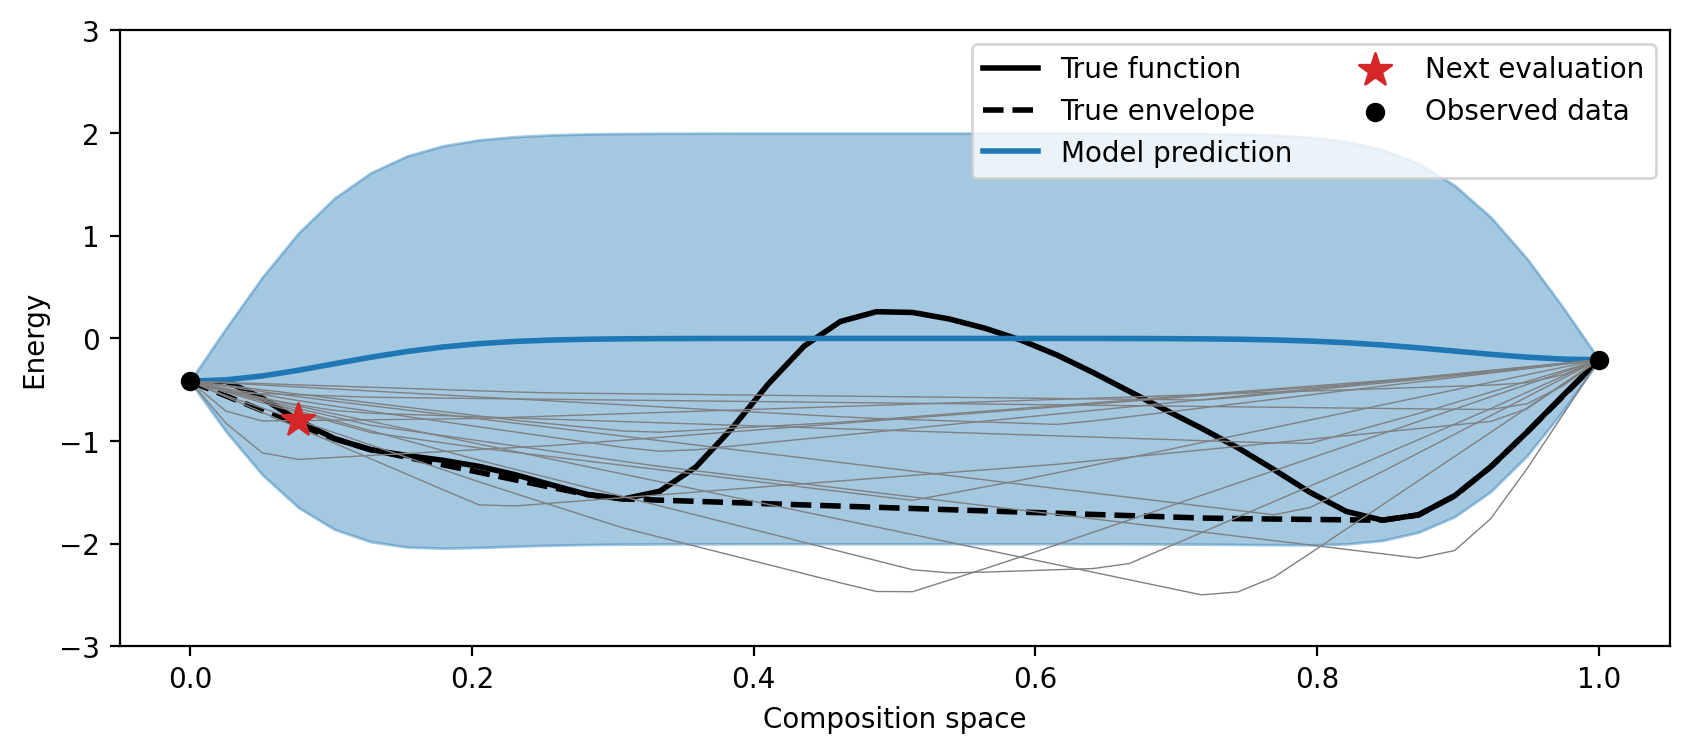

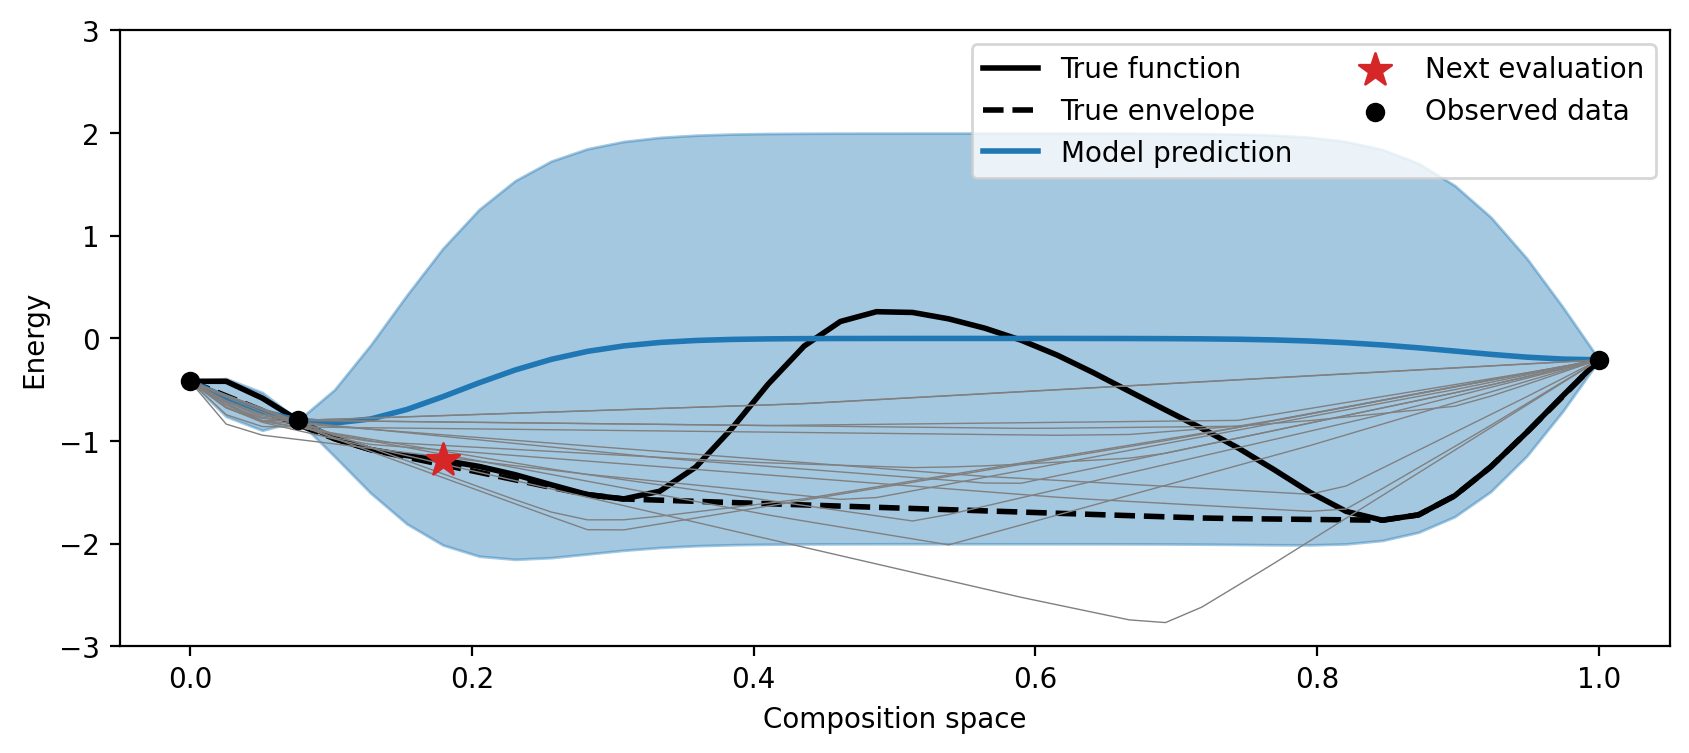

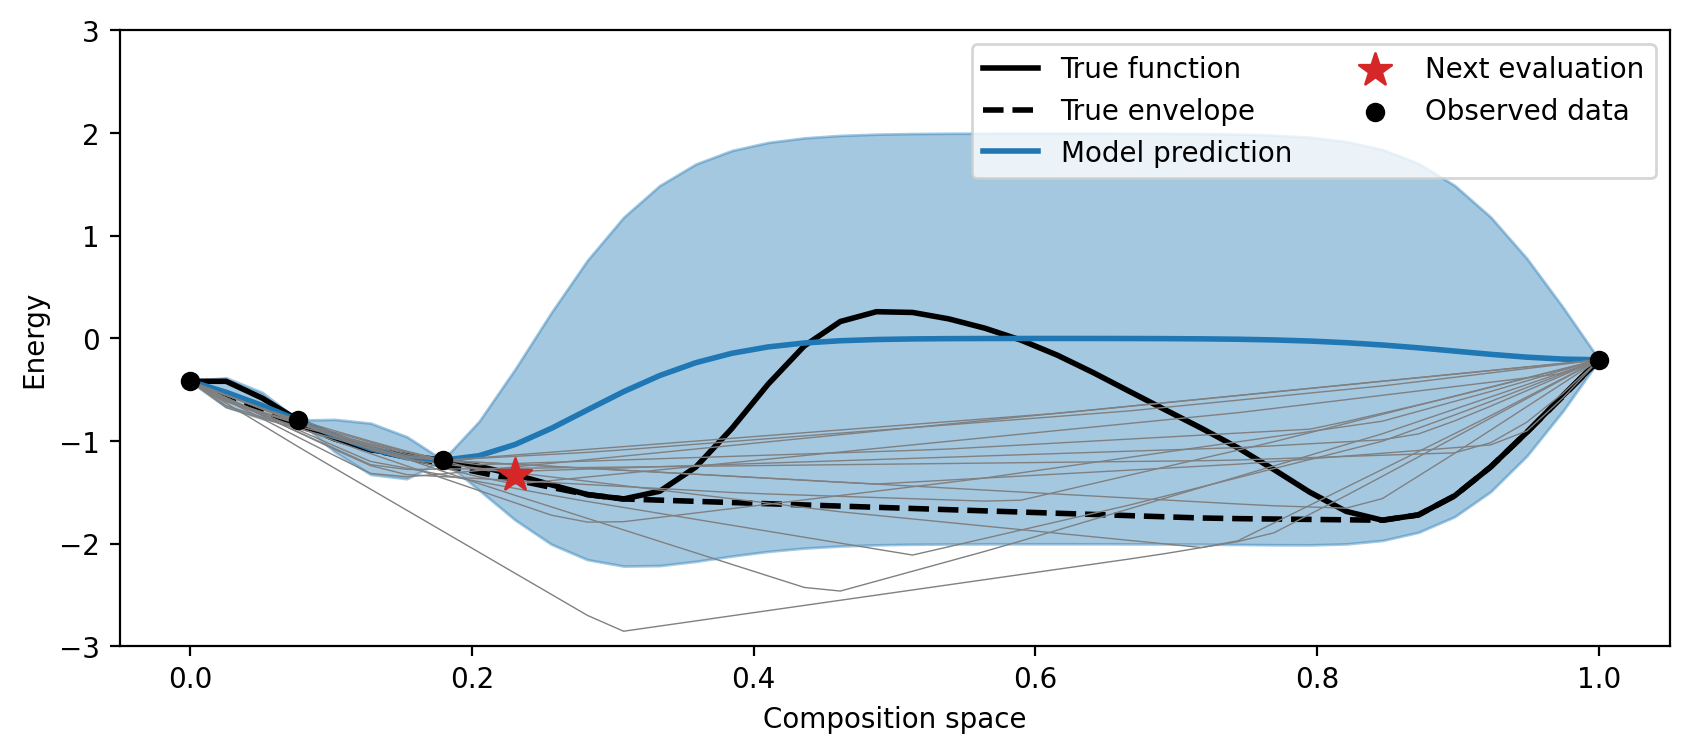

In [21]:
for i in range(num_iters):
    print("Iteration: ", i)
    
    %time next_x, entropy_change = get_next_candidate_noqhull(posterior, params, dataset, designs, design_space, rng_key, T=50, J=50)
    print(next_x, entropy_change)
    
    _, envelopes, _ = sample_from_posterior(pred_mean, pred_cov, design_space, 15, get_env=True)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes, dataset, next_x, entropy_change, plot_eig=False, plot_hulls=True, designs=designs)

    # add observations to data and update list of designs
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(get_next_y(true_y, design_space, next_x)))
    
    designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    
    # update model
    pred_mean, pred_cov, posterior, params = update_model_gpjax(dataset, design_space, rng_key, update_params=False)
    


# With qhull

In [22]:
seed = 2
num_iters = 10
knot_N = 40
npr.seed(seed); rng_key = jrnd.PRNGKey(1)

# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

true_y, true_envelope = generate_true_function(design_space, knot_N)

# Let's imagine that we start out by observing the two end points.
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])

#designs = design_space
designs = design_space[1:-1]


CPU times: user 2.65 ms, sys: 419 µs, total: 3.07 ms
Wall time: 3.5 ms
CPU times: user 1.68 ms, sys: 286 µs, total: 1.97 ms
Wall time: 2.06 ms


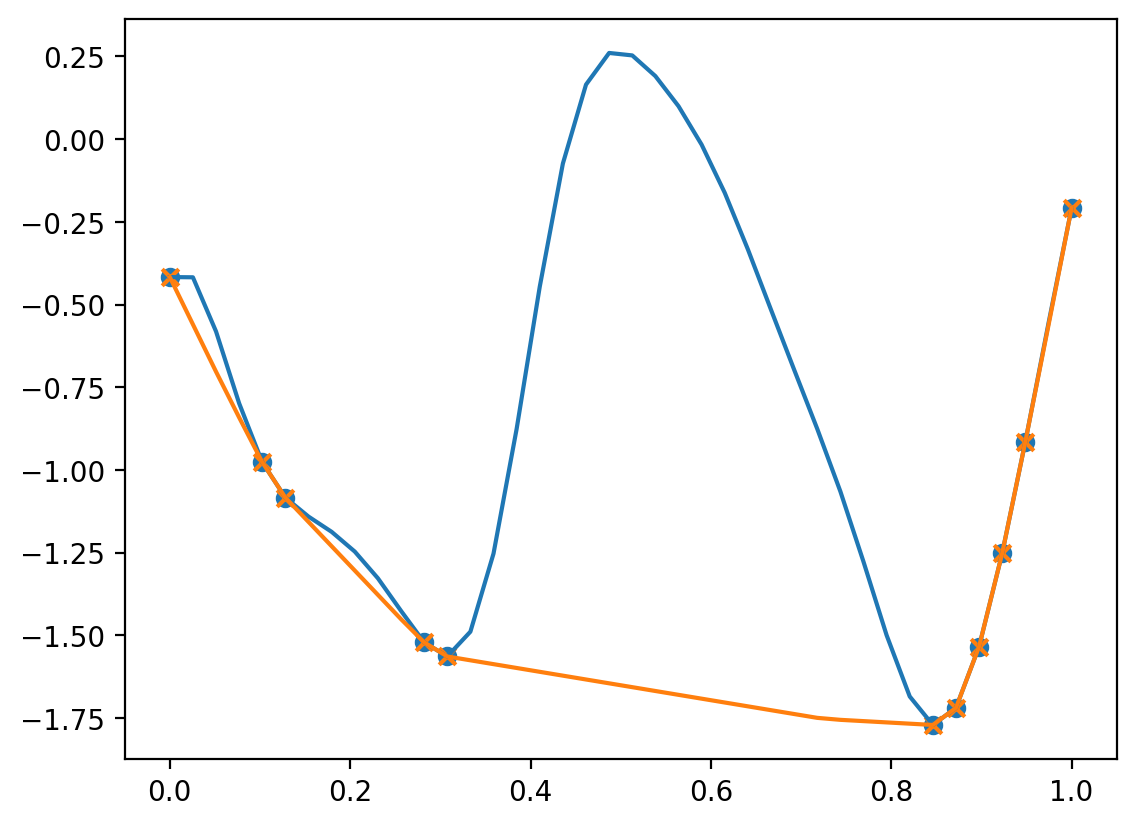

In [23]:
plt.plot(design_space, true_y)
plt.plot(design_space, true_envelope.T)

# this doesn't compute the hull, just the points on the hull
conv = %time convex_envelope(design_space, true_y)
plt.scatter(design_space[conv], true_y[conv])

conv2 =  %time convex_envelope_new(design_space, true_y)
plt.scatter(design_space[conv2], true_y[conv2], marker="x")

In [24]:
# update model
pred_mean, pred_cov, posterior, params = update_model_gpjax(dataset, design_space, rng_key, update_params=False)

In [25]:
pred_Y, envelopes, pred_cK = sample_from_posterior(pred_mean, pred_cov, design_space, 10, get_env=True)
    
print("sampled from posterior")

#breakpoint()
#tights = jnp.abs(envelopes.T - pred_Y) < tol ## NOTE: we transposed the shape from what it was before
get_tights = jax.jit(jax.vmap(lambda y: is_tight(design_space, y), in_axes=(1,)))
tights = get_tights(pred_Y).T

sampled from posterior


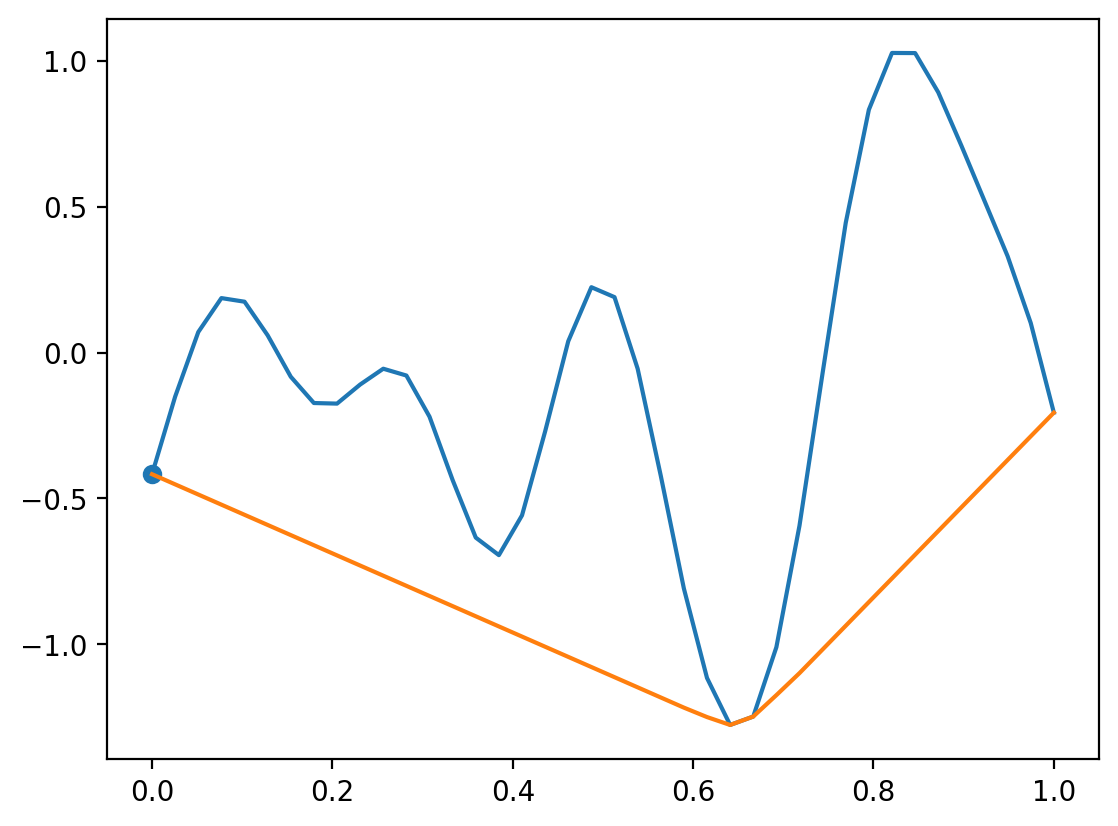

In [27]:
fx = pred_Y[:,0]
env = envelopes[0, :]
plt.plot(design_space, fx)
plt.plot(design_space,  env)

# this doesn't compute the hull, just the points on the hull
#conv = convex_envelope(design_space, true_y)
#conv = convex_envelope(design_space, fx)
conv = convex_envelope_new(design_space, fx)[0]

plt.scatter(design_space[conv],  fx[conv])

In [142]:
convex_envelope_old(design_space, fx)[0]

array([ 0, 25, 26, 39])

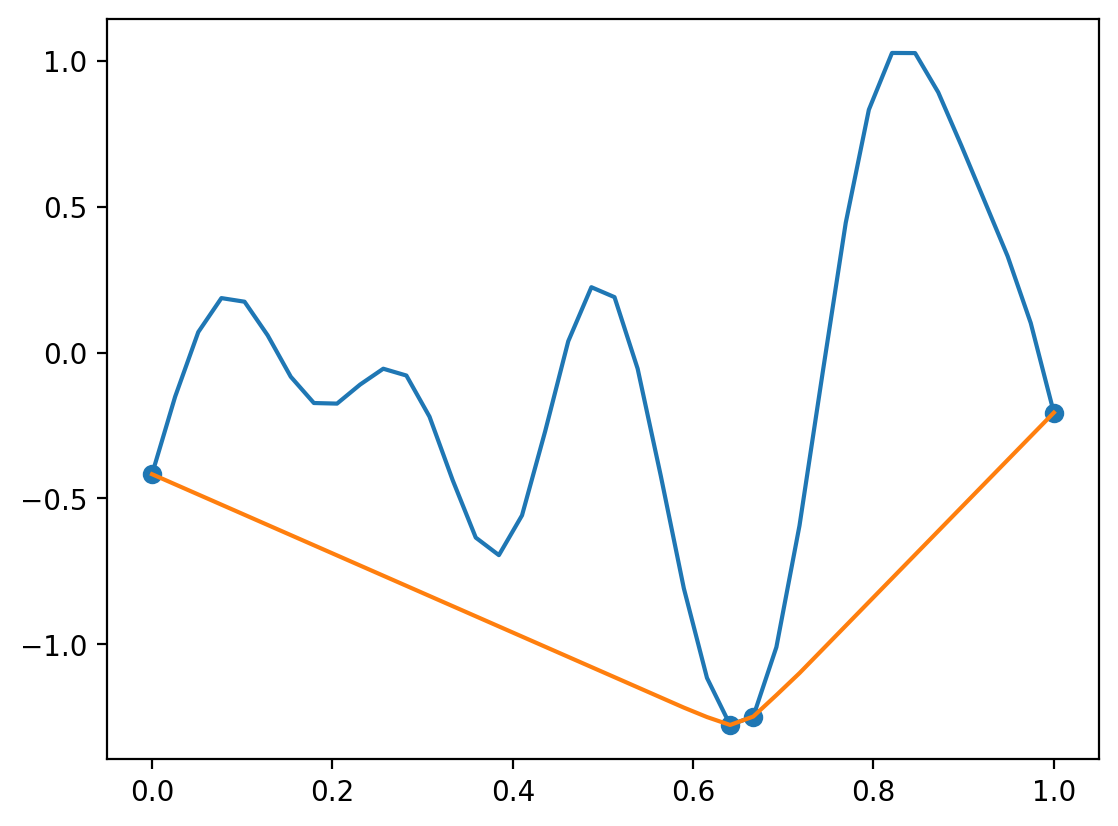

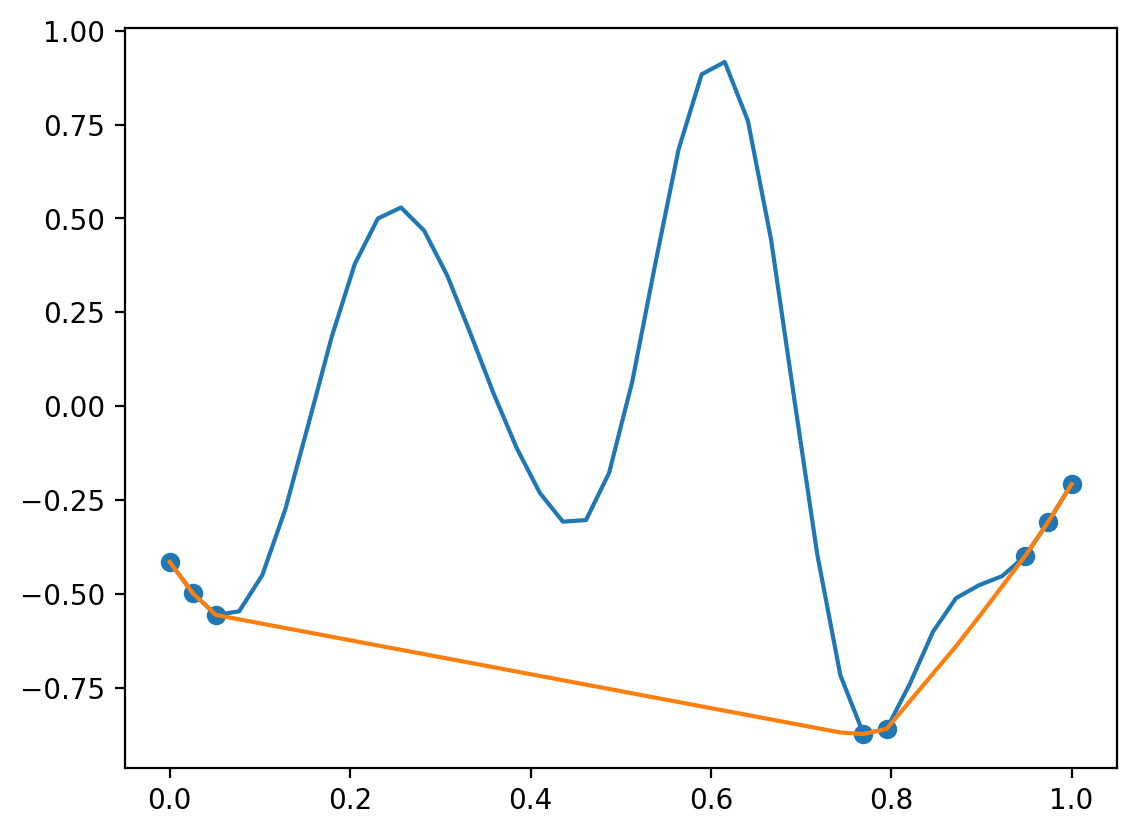

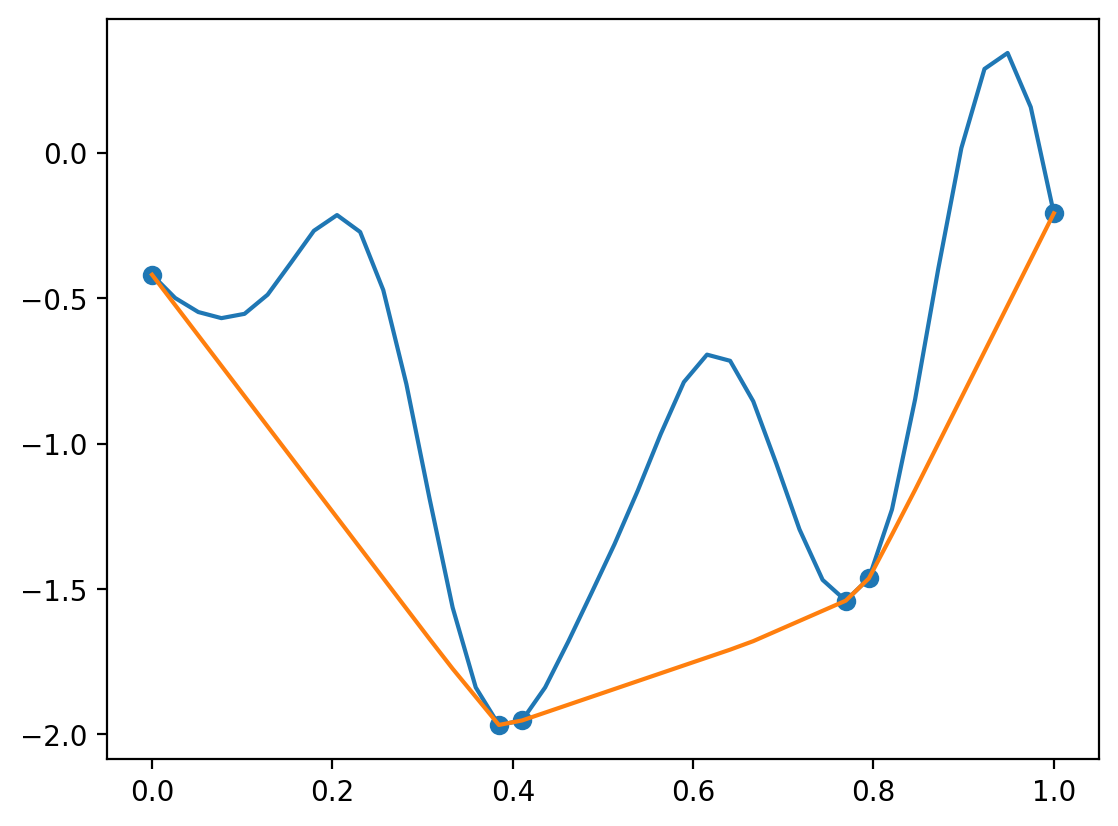

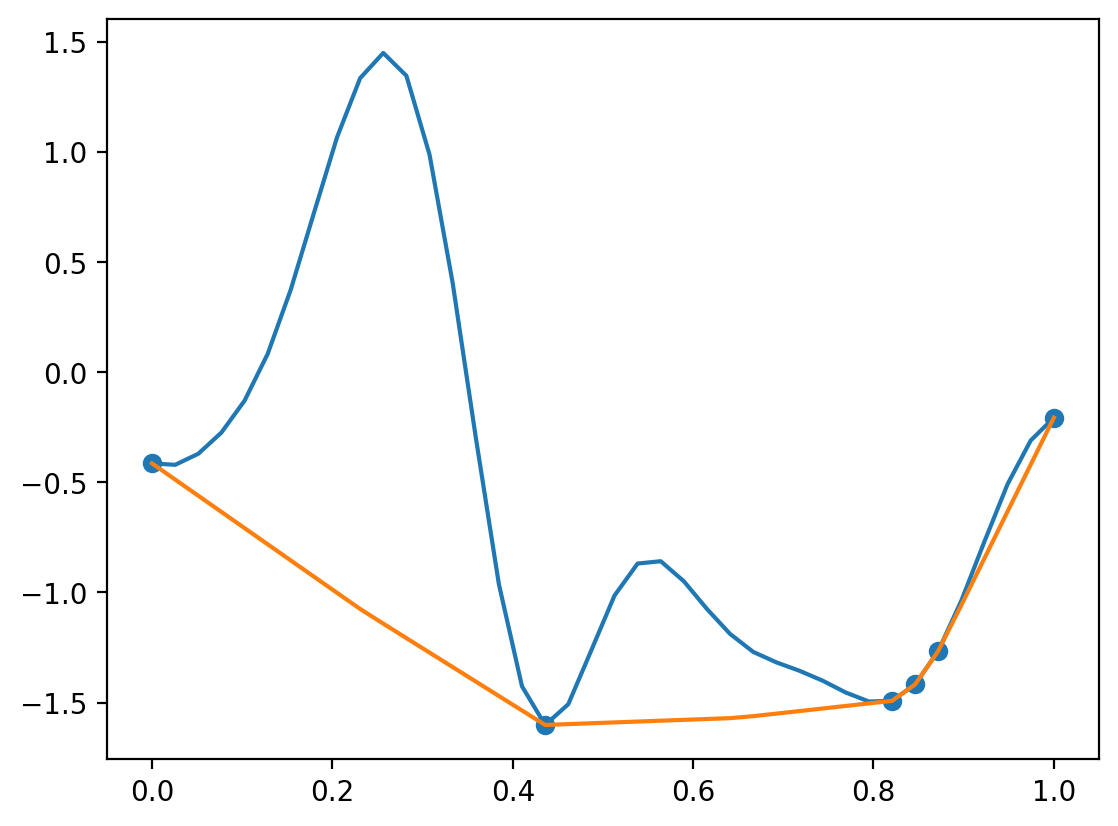

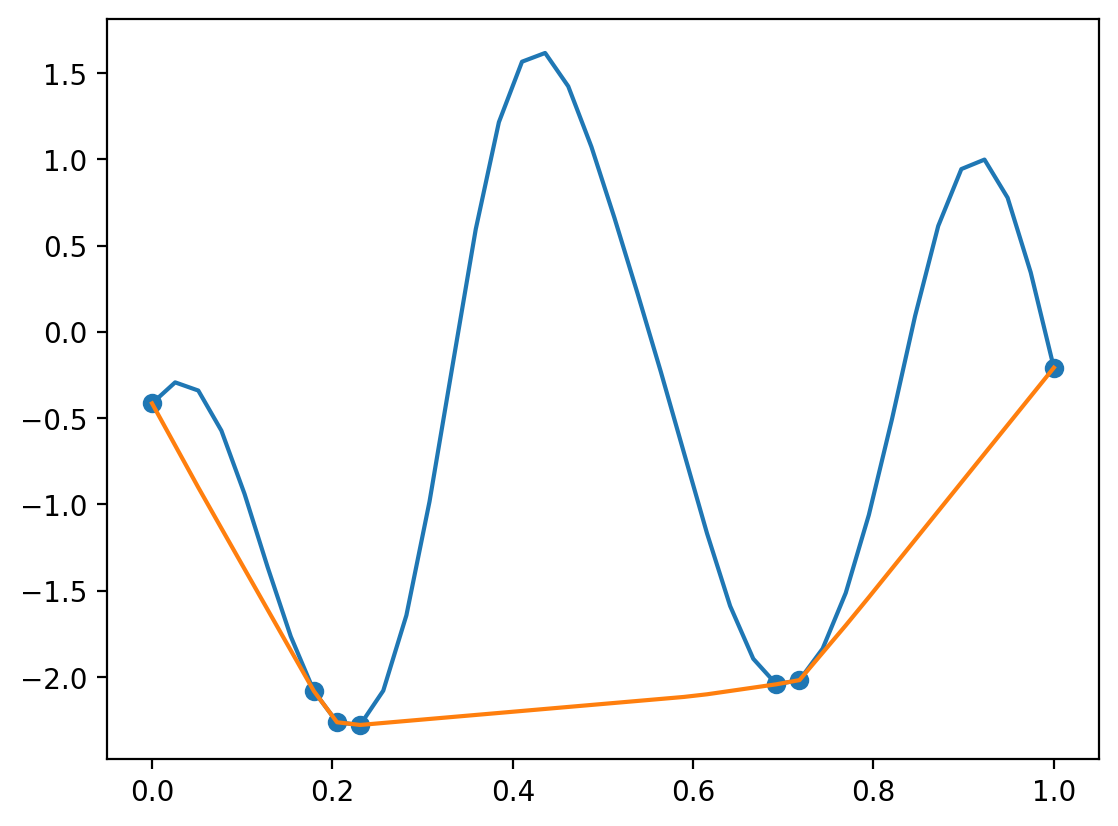

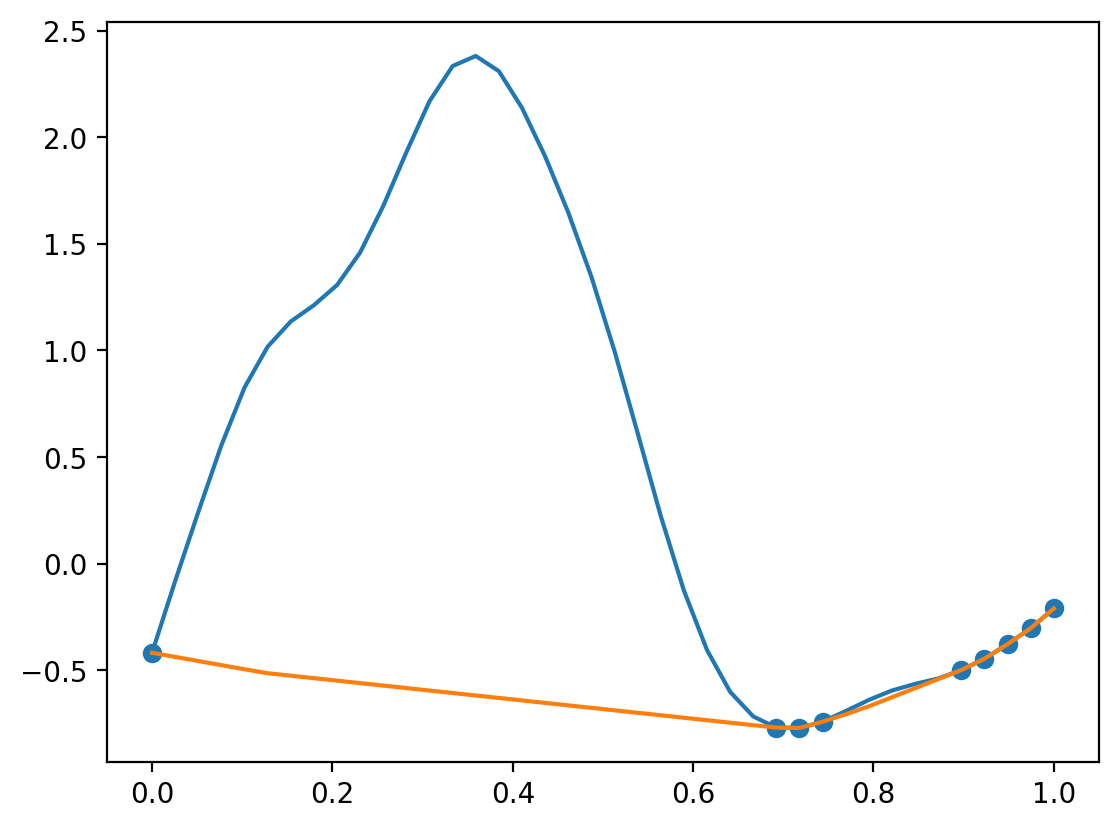

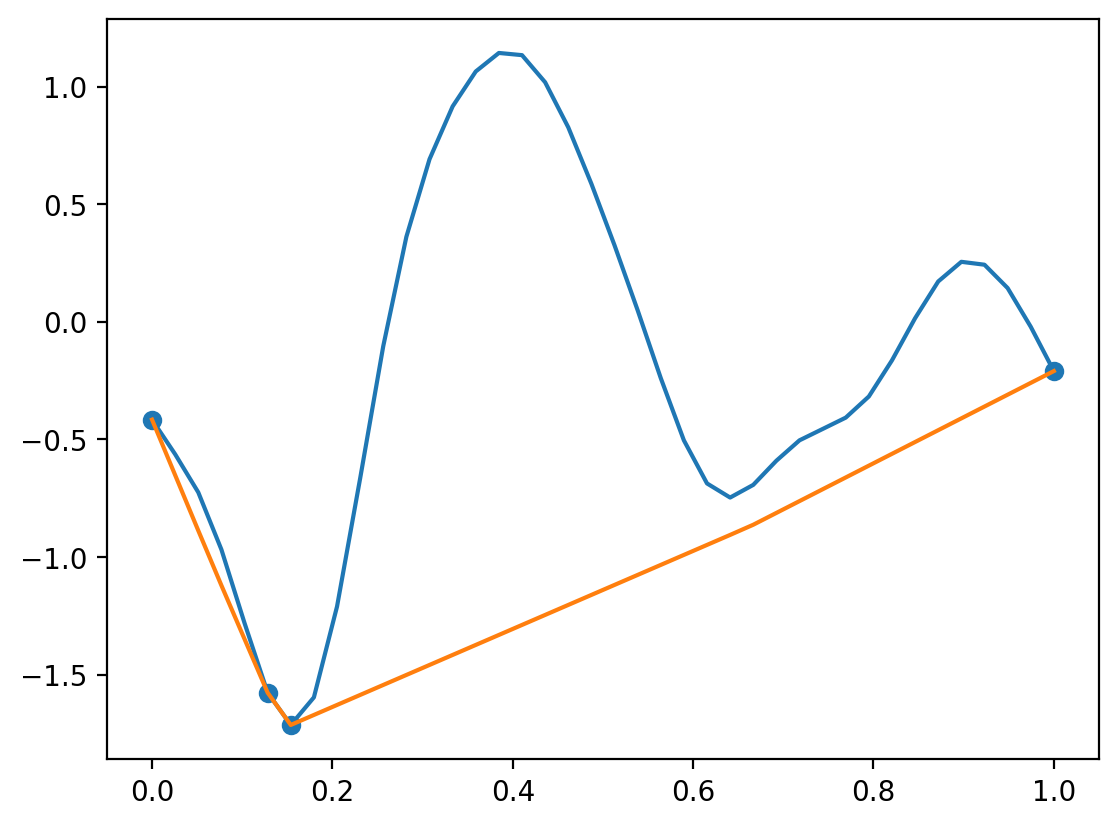

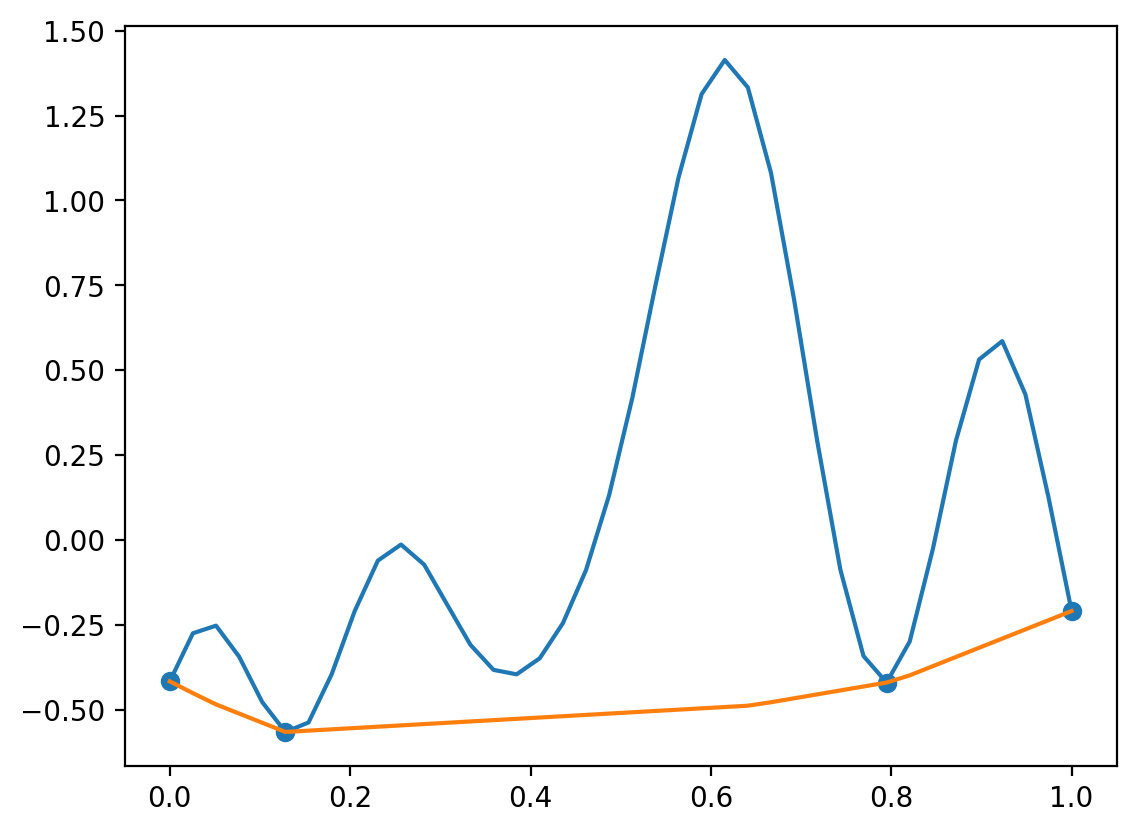

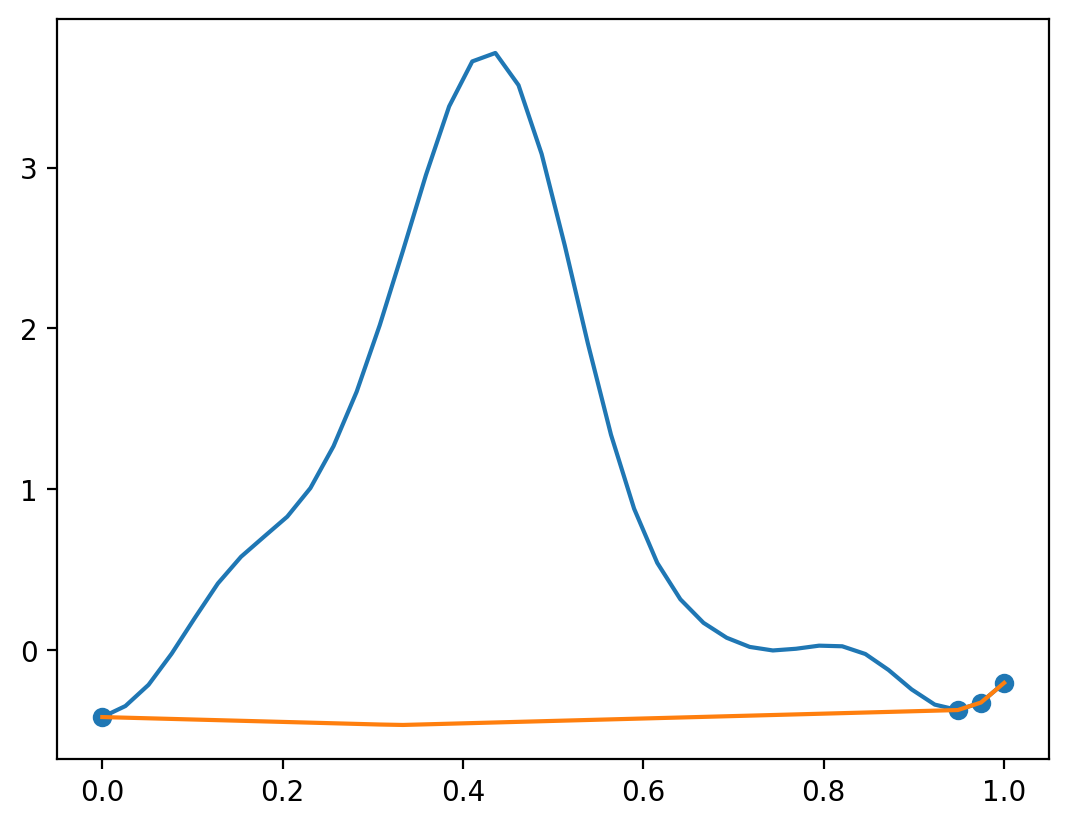

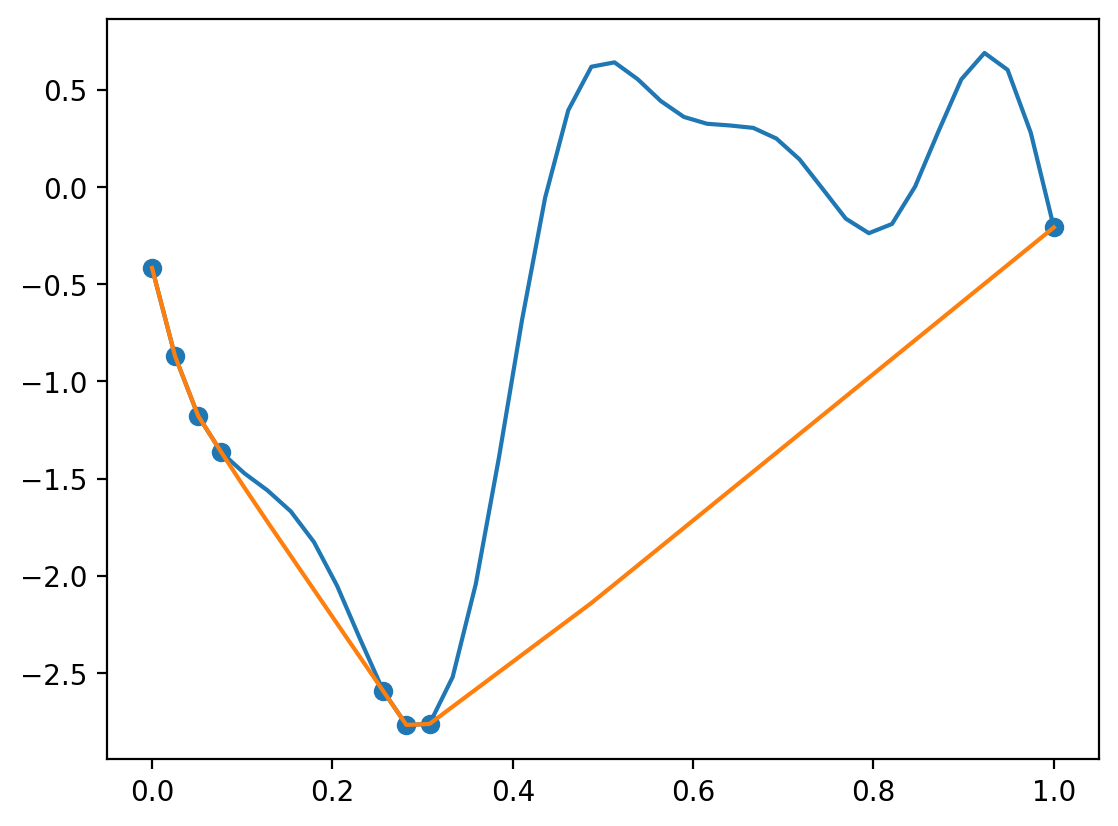

In [28]:
for i in range(10):
    plt.figure()
    plt.plot(design_space, pred_Y[:,i])
    plt.plot(design_space, envelopes[i, :])
    plt.scatter(design_space[tights[:, i]], pred_Y[:,i][tights[:, i]])

Iteration:  0
CPU times: user 3min 14s, sys: 31.4 s, total: 3min 46s
Wall time: 3min 53s
[0.1025641] [1.49440506 1.52137405 1.54527548 1.57038822 1.53985549 1.53547917
 1.54369589 1.5307694  1.52279619 1.47396779 1.44148356 1.43300848
 1.43406531 1.4661494  1.48594155 1.44690851 1.38415751 1.33434433
 1.3067766  1.30661867 1.29715486 1.267242   1.23067112 1.22539985
 1.24656851 1.28890153 1.33634116 1.37050592 1.39987252 1.42215013
 1.4727016  1.52819357 1.55817703 1.5626709  1.5517733  1.51775909
 1.4799023  1.45120905]
Iteration:  1
CPU times: user 3min 24s, sys: 32.9 s, total: 3min 57s
Wall time: 4min 5s
[0.05128205] [2.18897413 2.21836888 1.98472415 1.94387065 2.14538719 2.14921039
 2.09195594 2.03637264 1.98169517 1.97127971 1.9929786  2.0014772
 2.00010011 2.01252591 2.01076269 2.00030047 1.96169194 1.9061913
 1.85391383 1.79102233 1.72279303 1.67632236 1.65116199 1.66600916
 1.72054603 1.77136602 1.79625496 1.8116904  1.82515463 1.84301217
 1.89009758 1.94564703 1.93482373 1.903

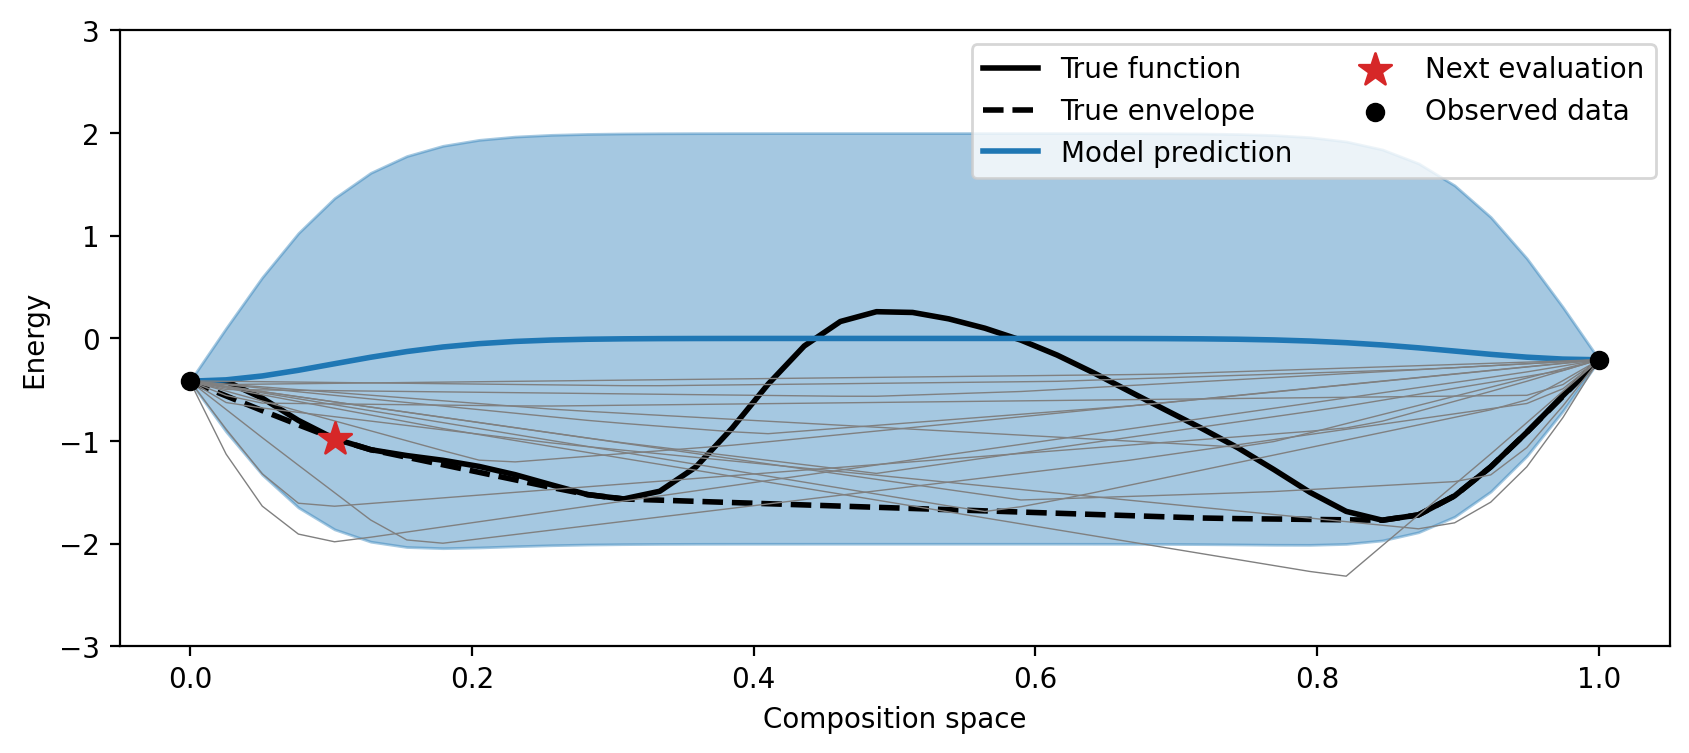

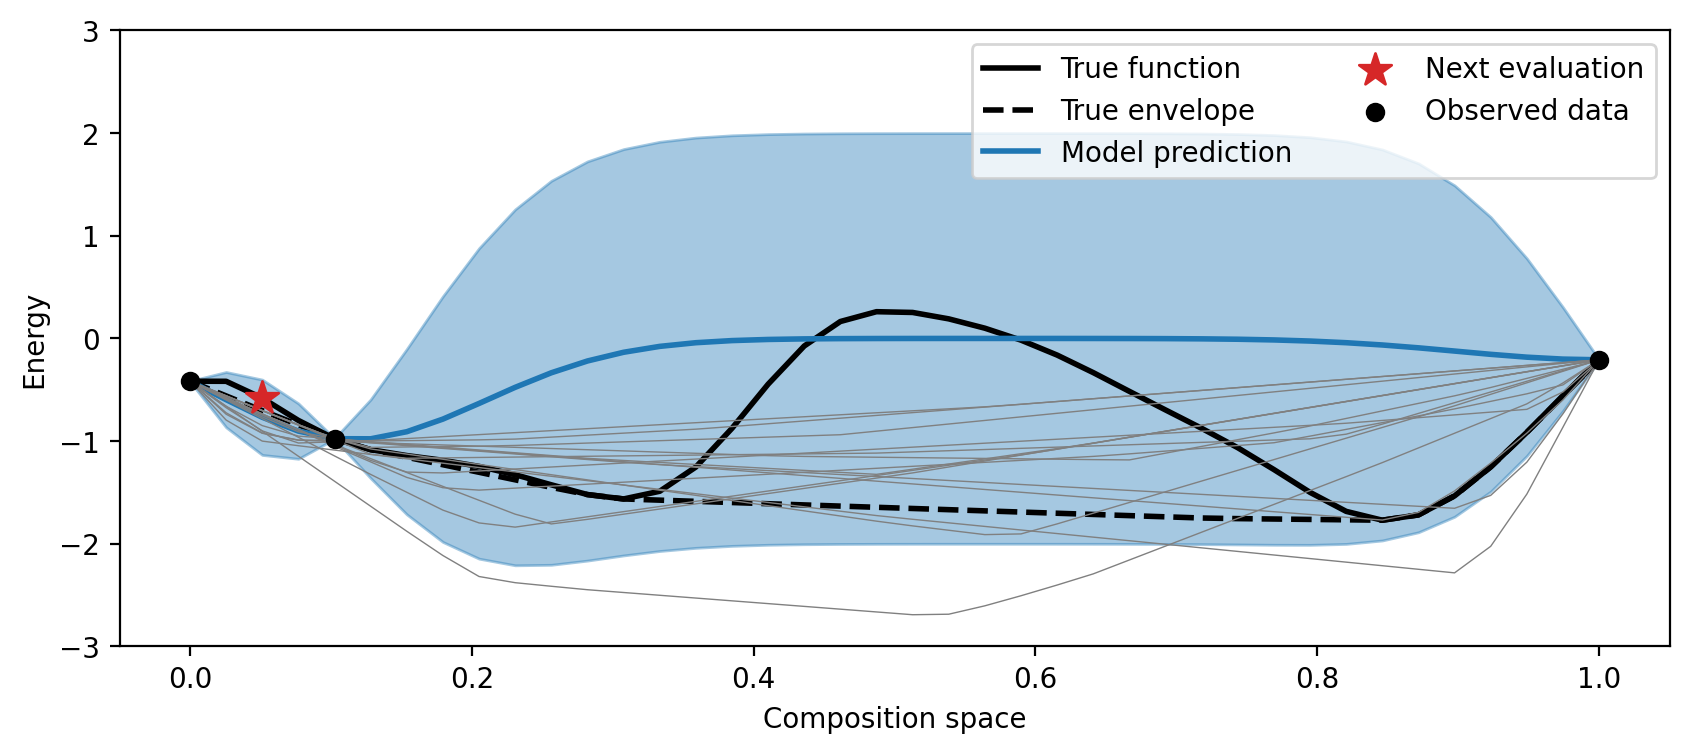

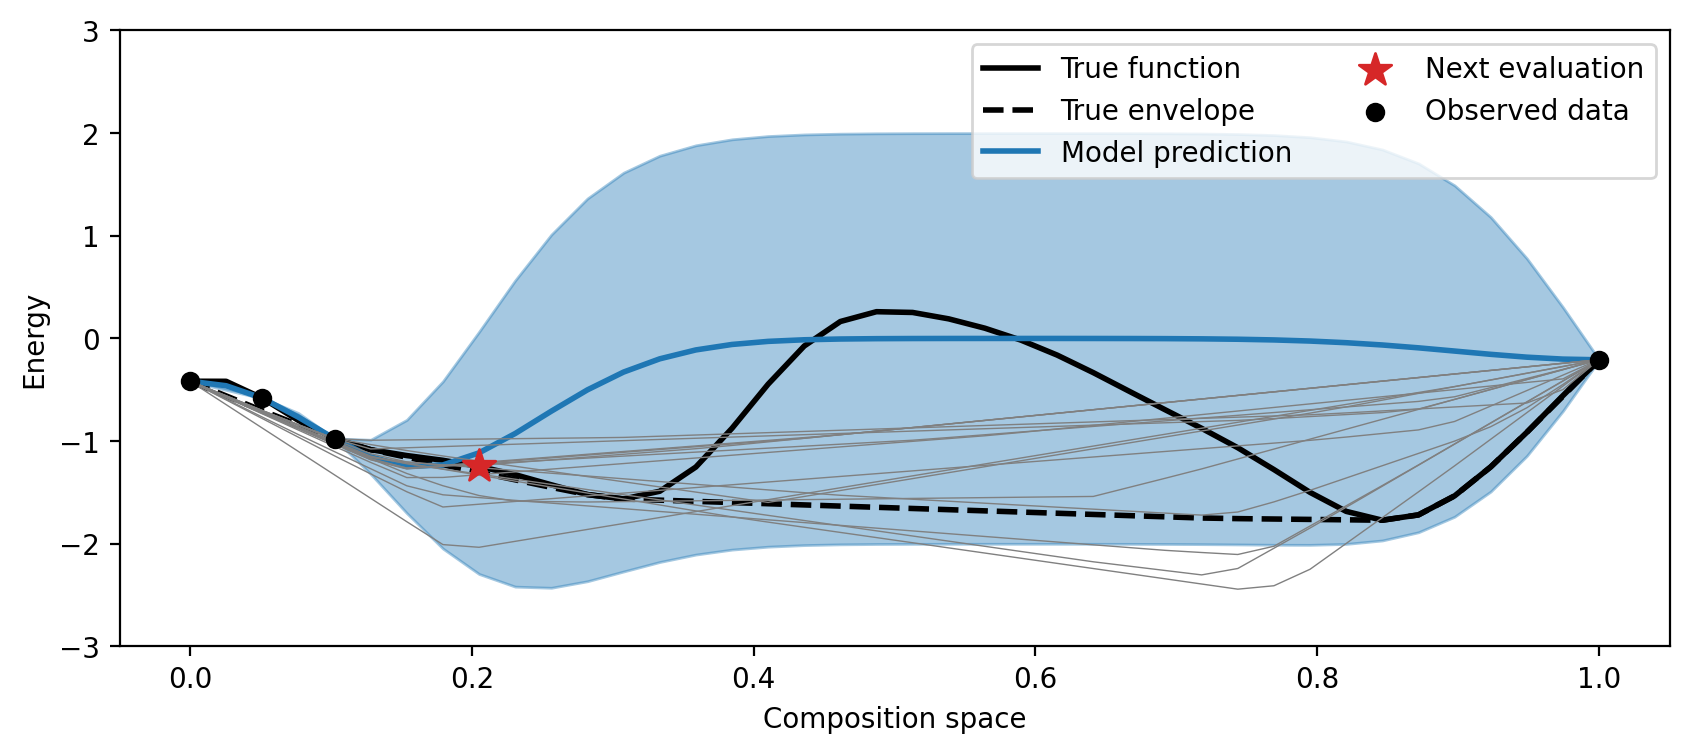

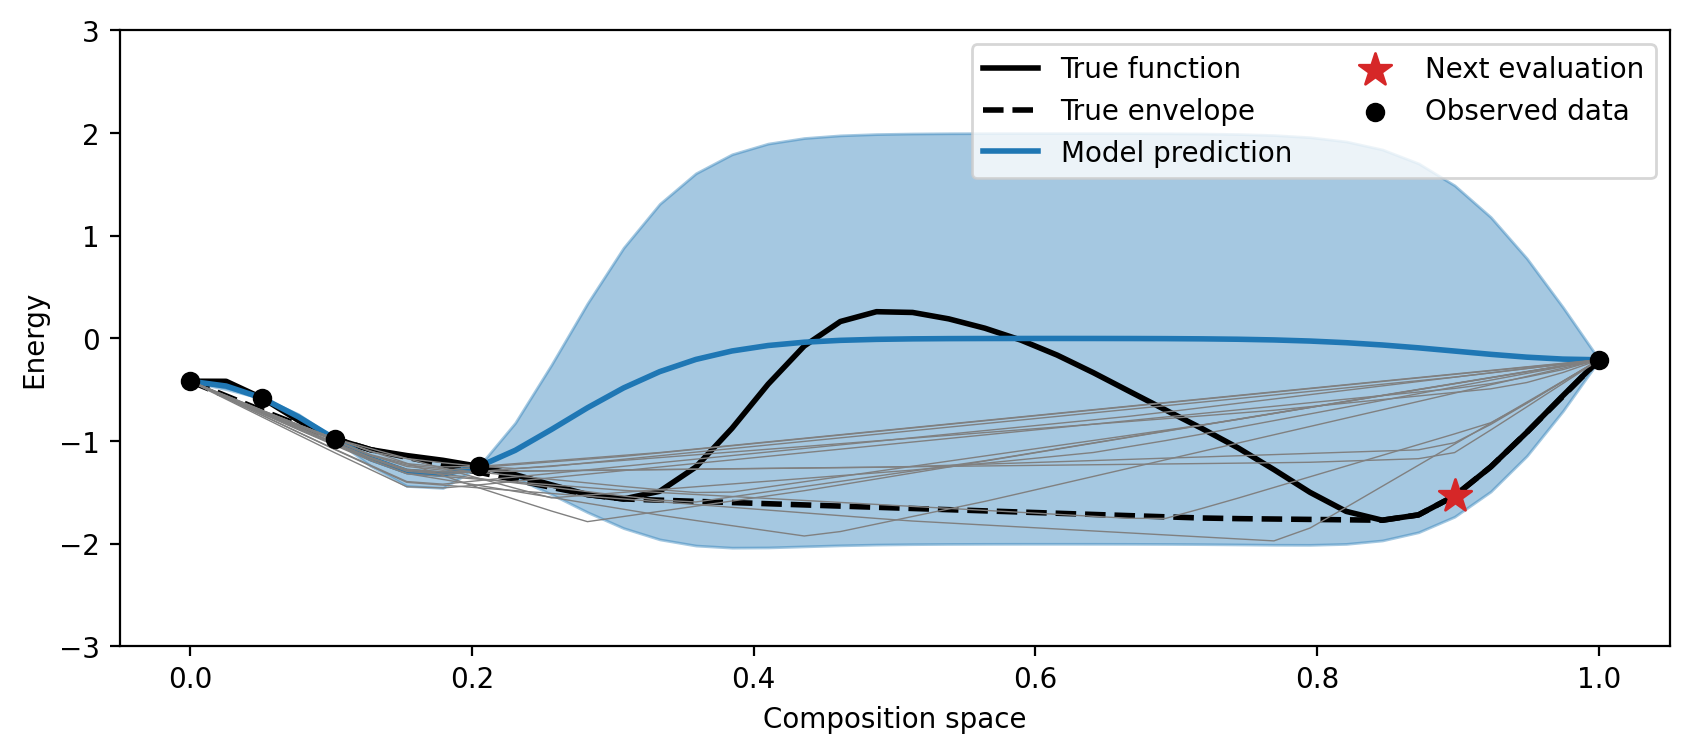

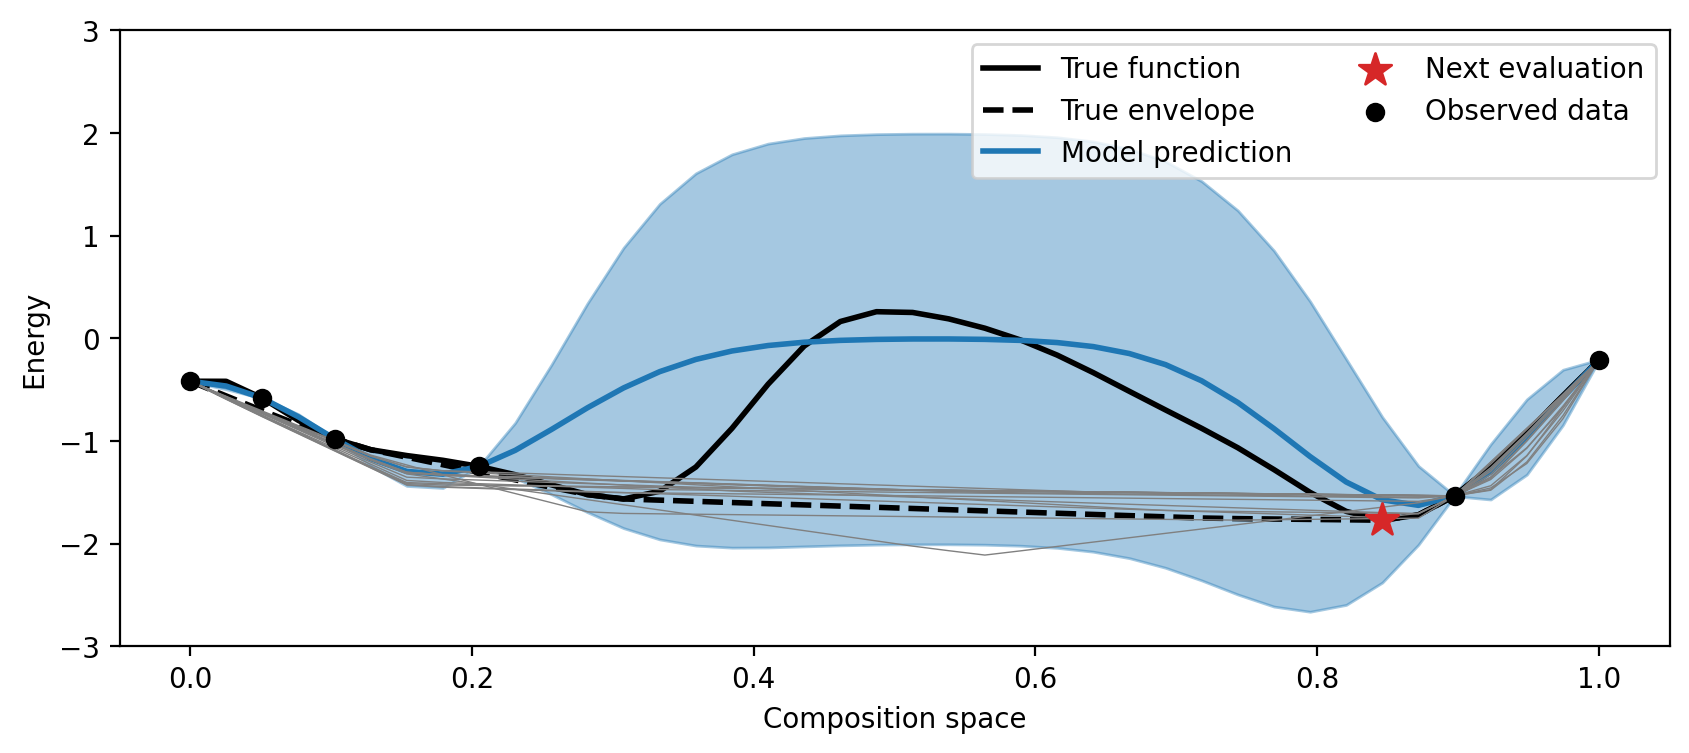

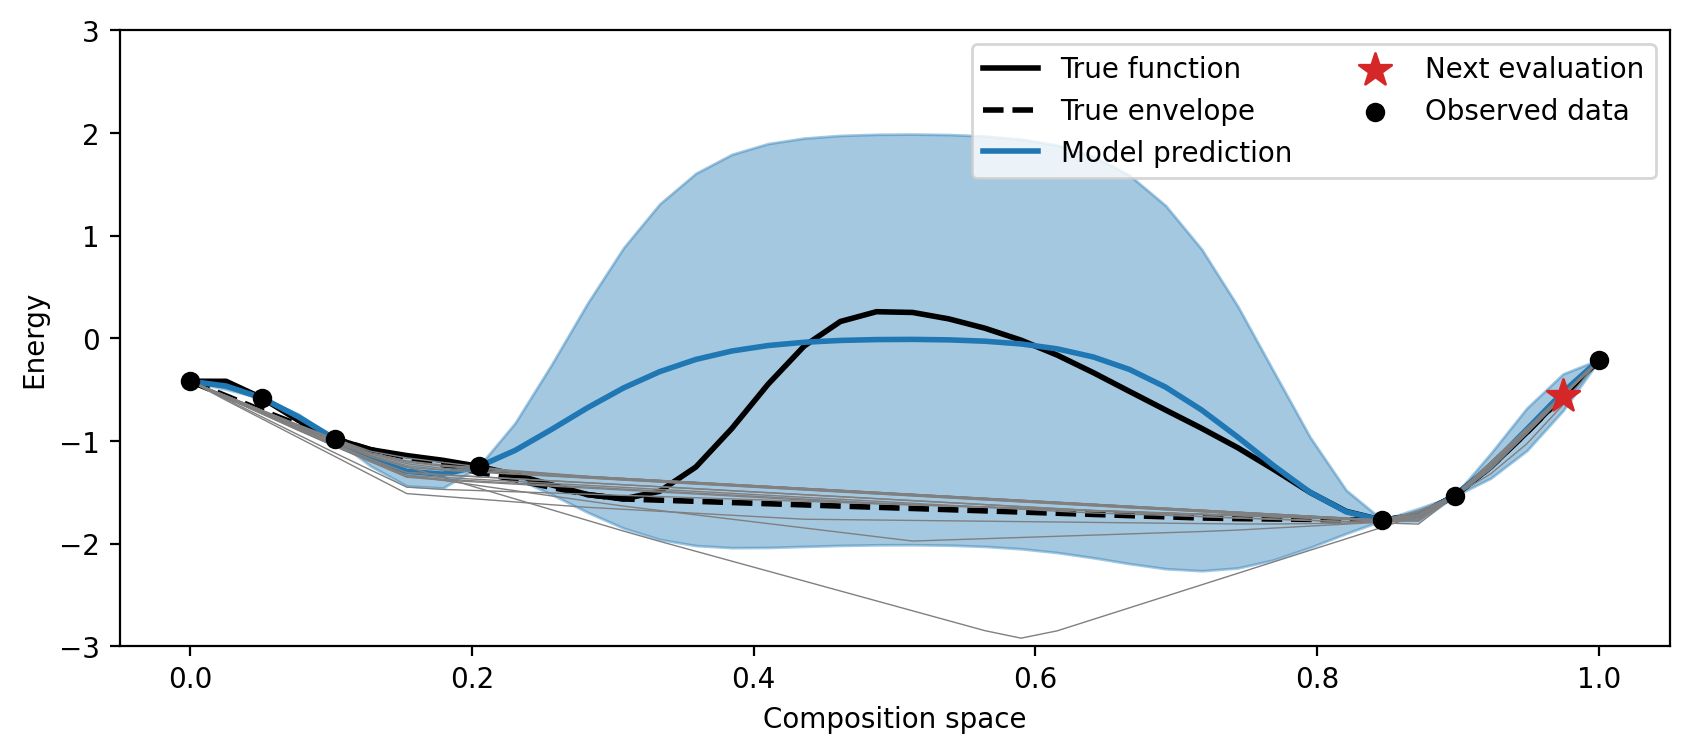

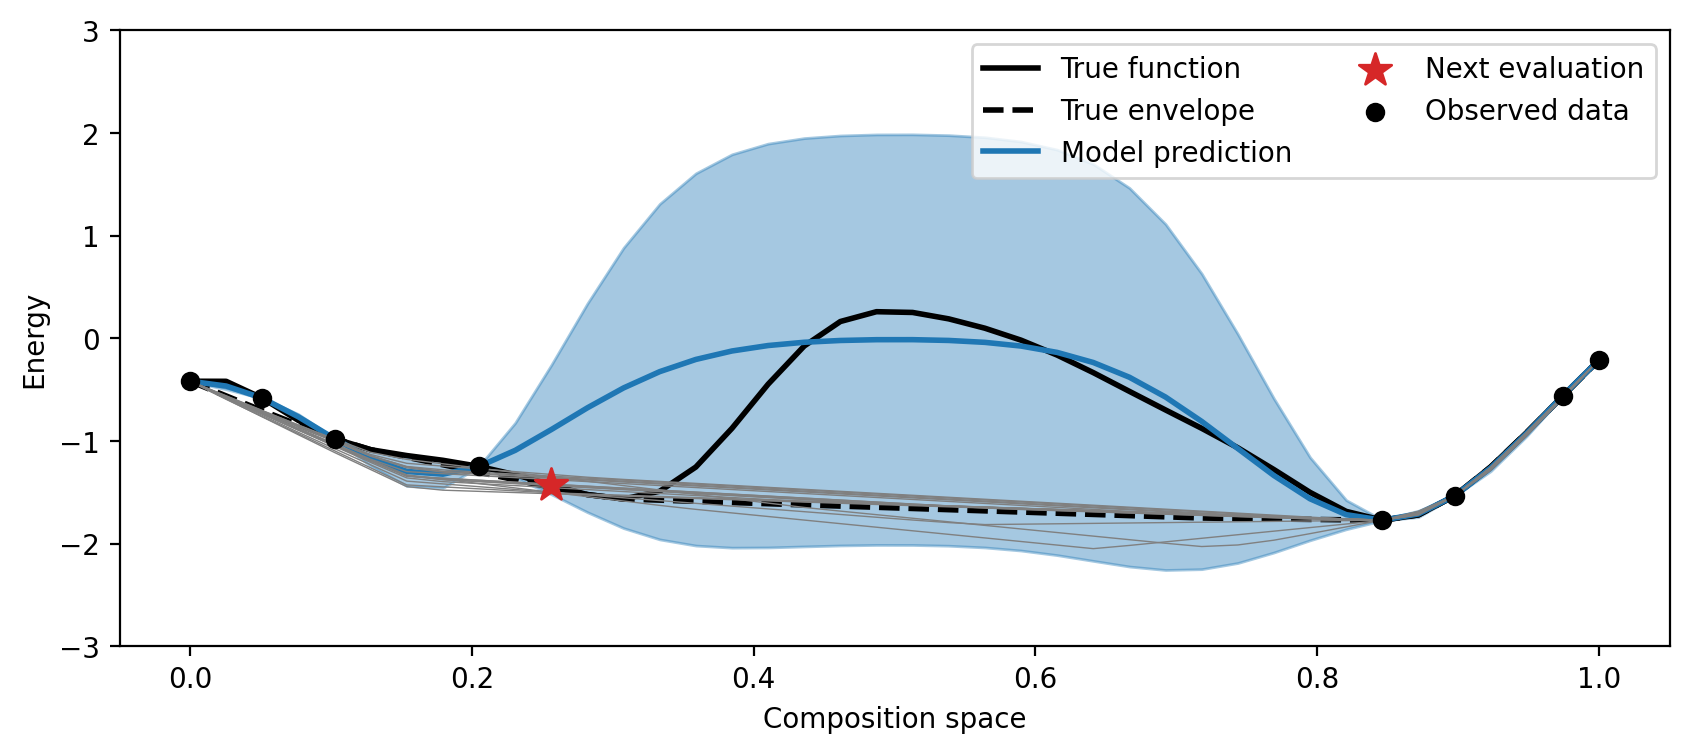

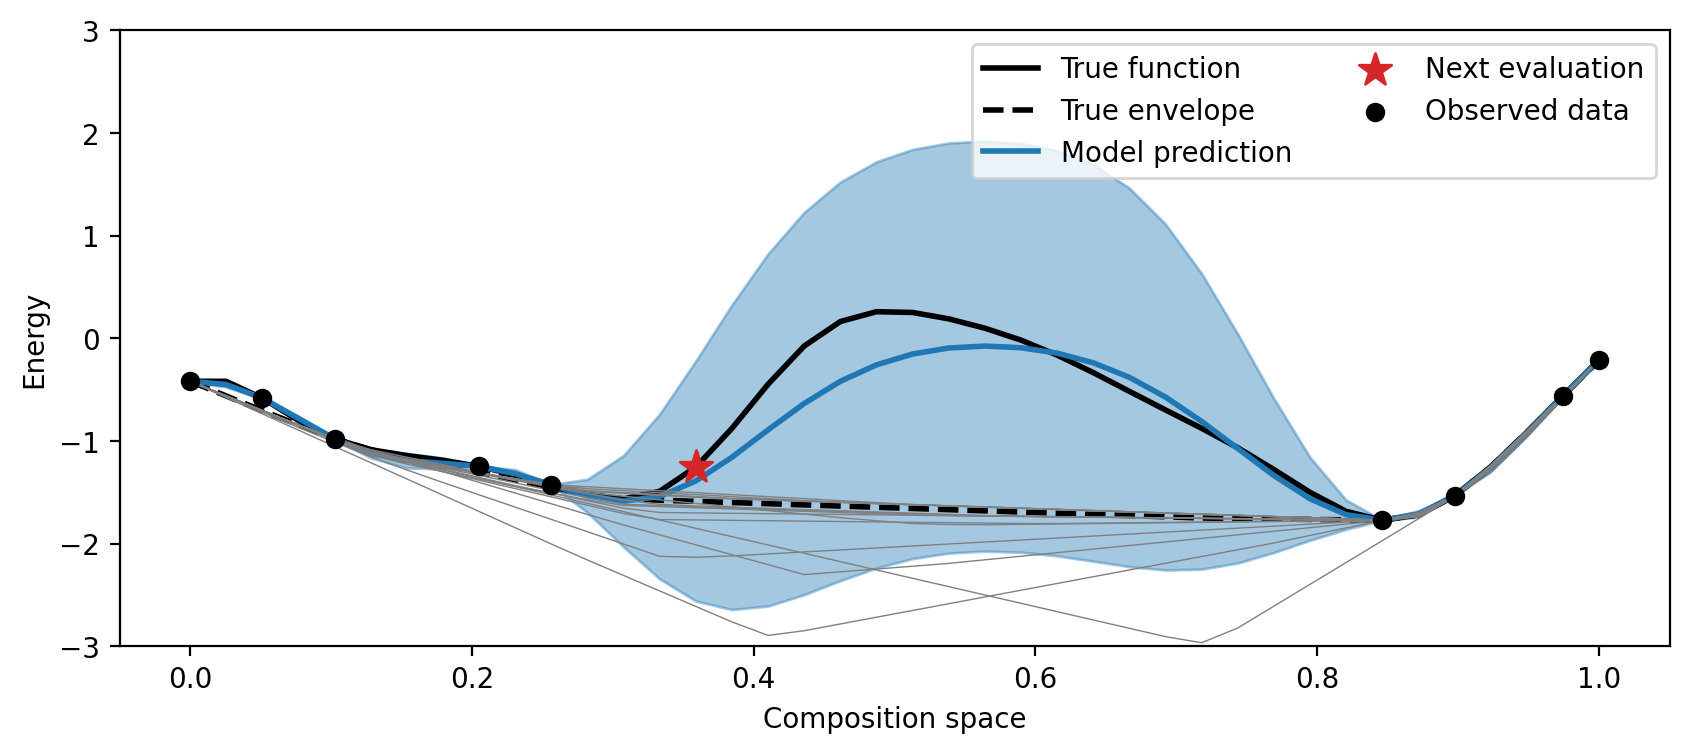

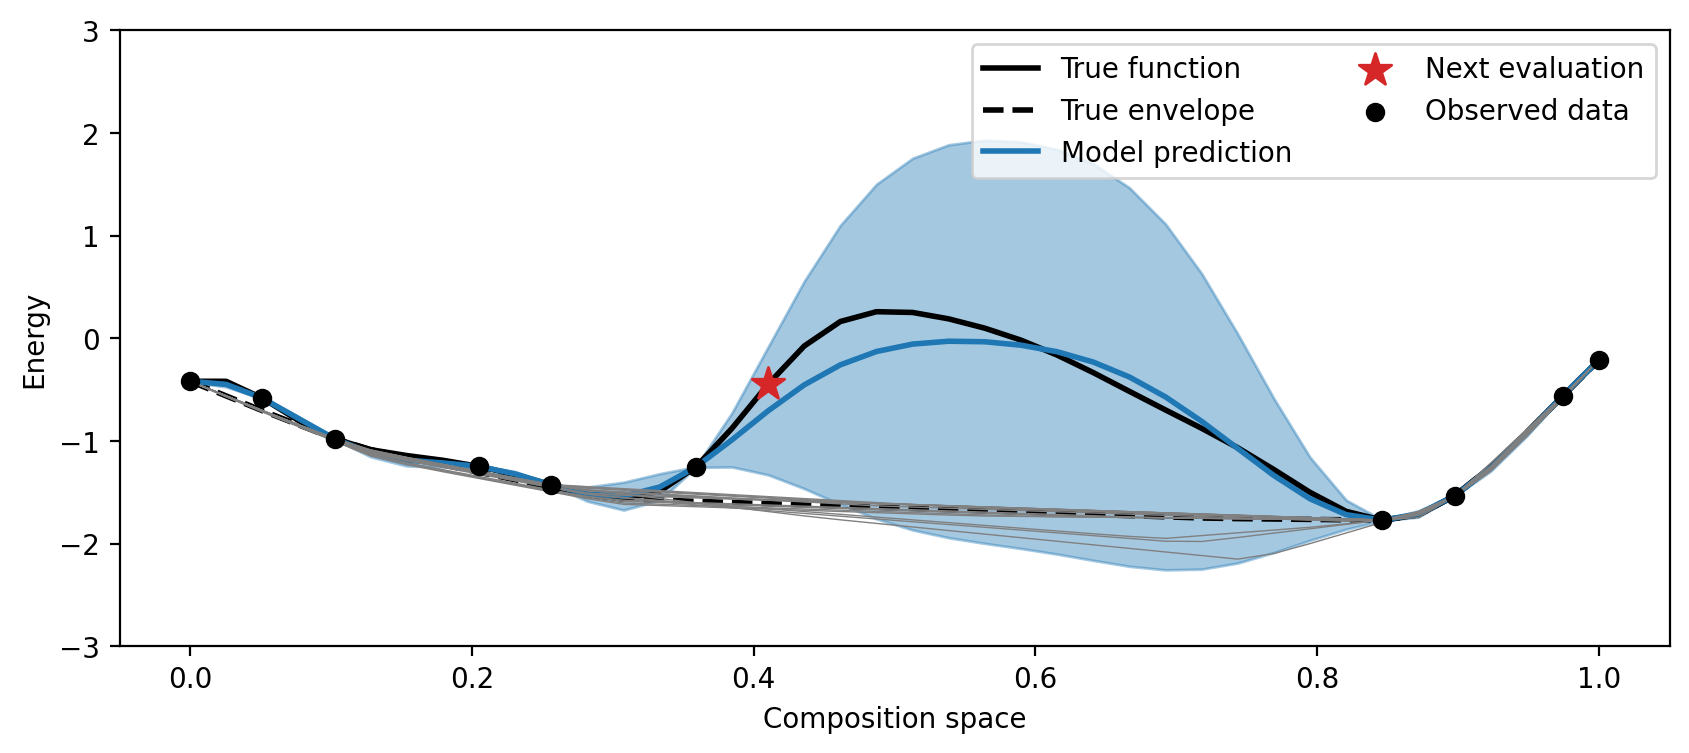

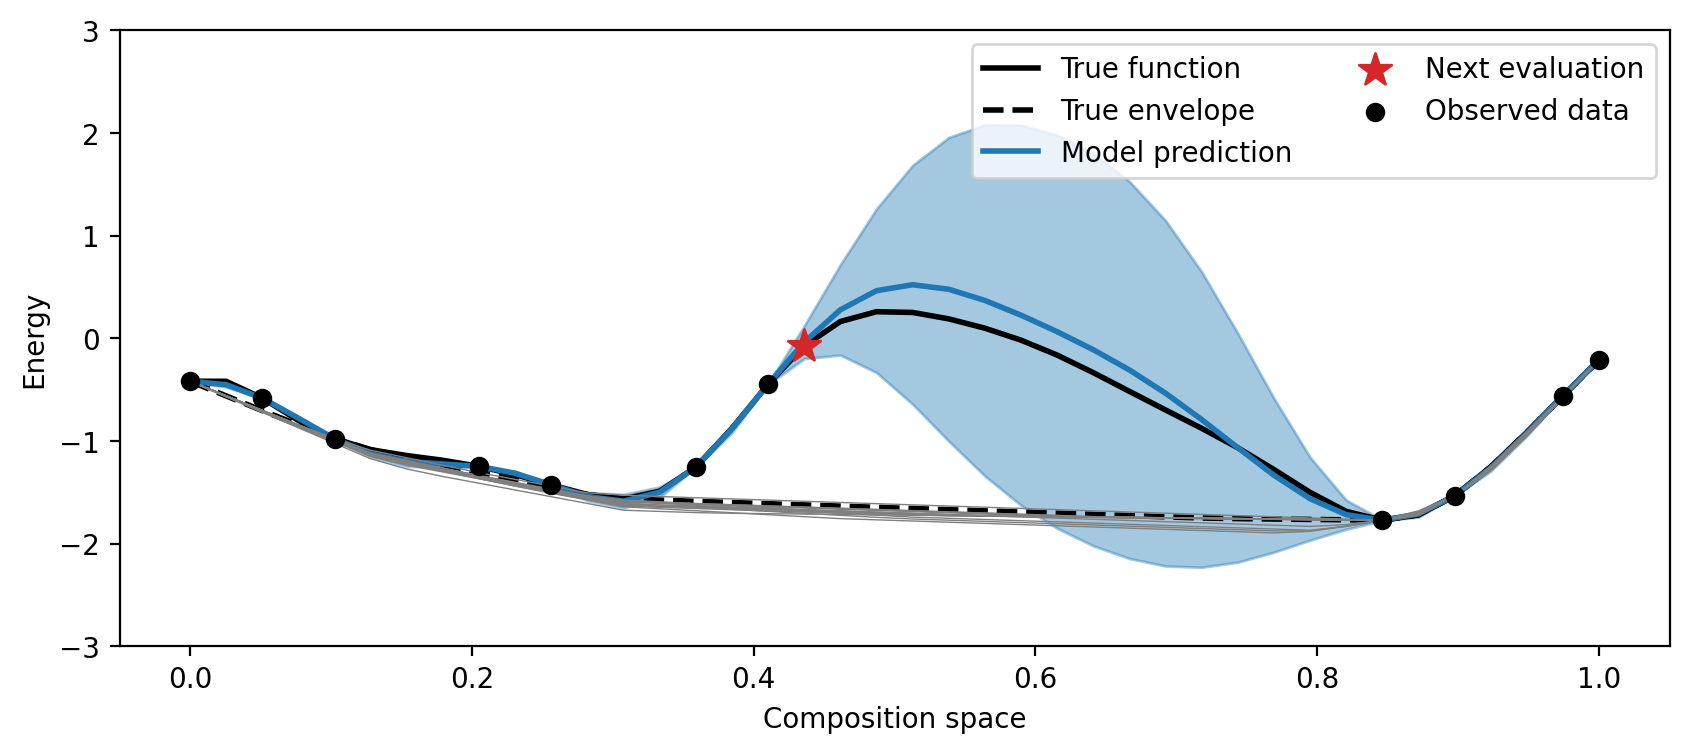

In [29]:
for i in range(num_iters):
    print("Iteration: ", i)
    
    %time next_x, entropy_change = get_next_candidate_qhull(posterior, params, dataset, designs, design_space, rng_key, T=50, J=50)
    print(next_x, entropy_change)
    
    _, envelopes, _ = sample_from_posterior(pred_mean, pred_cov, design_space, 15, get_env=True)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes, dataset, next_x, entropy_change, plot_eig=False, plot_hulls=True, designs=designs)

    # add observations to data and update list of designs
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(get_next_y(true_y, design_space, next_x)))
    
    designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    
    # update model
    pred_mean, pred_cov, posterior, params = update_model_gpjax(dataset, design_space, rng_key, update_params=False)
    
